# MP1 MountainCar Miniproject Notebook

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import secrets

## 2 Random Agent Class

This code block describes the implementation of a random agent as described in task 2 of the project handout.

In [2]:
class RandomAgent:
    def __init__(self, environment):
        """Initializes the random agent with the given environment."""
        self.env = environment

    def observe(self, state, action, next_state, reward):
        """Observe the environment (state, action, next_state, reward).
        This is a placeholder for the random agent, as it does not learn from the environment."""
        return

    def select_action(self, state):
        """Randomly select an action from the action space.
        The state is not used in this method because the action is selected randomly."""
        return self.env.action_space.sample()

    def update(self):
        """Update the agent. No update is needed for the random agent."""
        return

Run the agent on the environment until the episode is either truncated or terminated. Store the episode and render (visualize) it.

In [3]:
def run_single_episode(agent):
    """Run the RandomAgent for a single episode.
    
    Parameters:
    - agent: An instance of the RandomAgent class.
    
    Returns:
    - episode_reward: The total reward obtained during the episode.
    - states: A list of states visited during the episode.
    """
    done = False
    state, _ = agent.env.reset() # Reset the environment and get the initial state
    episode_reward = 0
    states = [state]

    while not done:
        action = agent.select_action(state) # Rndomly select an action
        next_state, reward, terminated, truncated, _ = agent.env.step(action) # Take the action in the environment
        episode_reward += reward
        
        # Observe and update does not do anything for the random agent
        agent.observe(state, action, next_state, reward)
        agent.update()
        
        state = next_state # Move to the next state
        states.append(state) # Keep track of the states visited

        done = terminated or truncated

    return episode_reward, states

In [4]:
def plot_states_over_time(states):
    """Plot a run of a single episode for the RandomAgent.
    """
    # Extract positions and velocities from states
    positions = [s[0] for s in states]
    velocities = [s[1] for s in states]
    timesteps = list(range(len(states)))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, positions, label='Position')
    plt.title('Car Position Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, velocities, label='Velocity')
    plt.title('Car Velocity Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Episode reward after taking random actions: -200.0


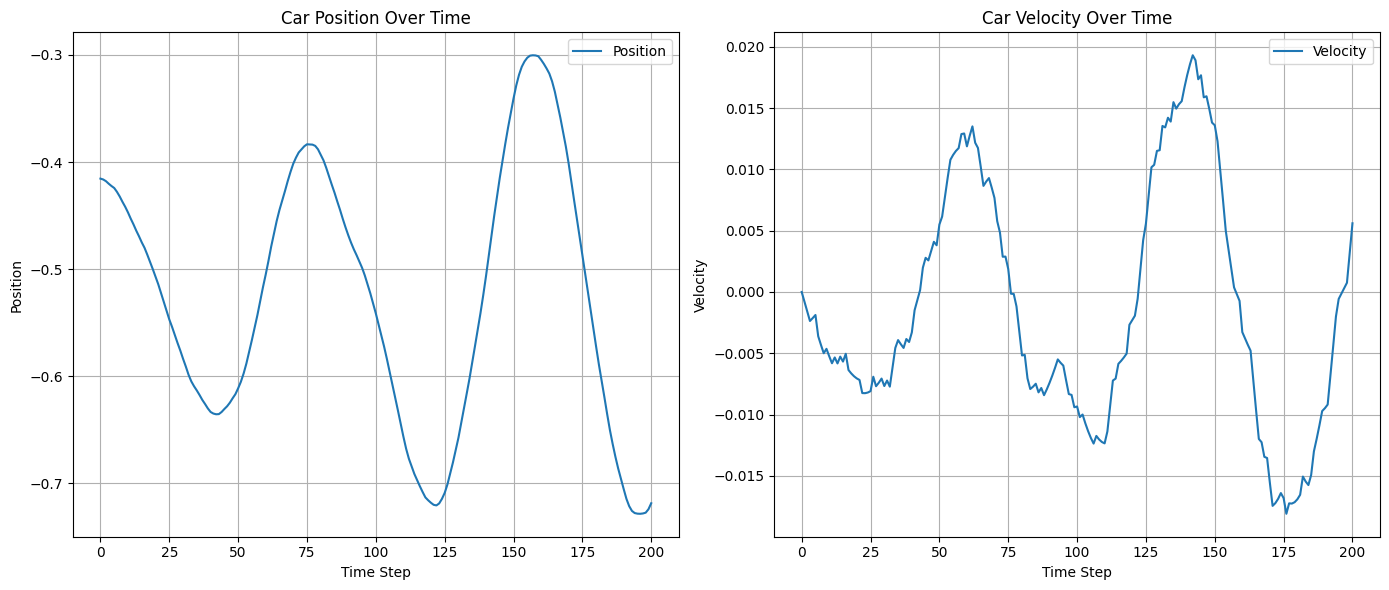

In [5]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
episode_reward, states = run_single_episode(random_agent)
print(f"Episode reward after taking random actions: {episode_reward}")
plot_states_over_time(states)

Run the agent for 100 episodes. At every episode initialize the environment with a new randomly sampled seed. Plot the duration of each episode as a scatter plot.

In [18]:
def run_multiple_episodes(agent, num_episodes=100):
    """Run the RandomAgent for multiple episodes.
    
    Parameters:
    - agent: An instance of the RandomAgent class.
    - num_episodes: The number of episodes to run the agent for.
    
    Returns:
    - episode_durations: A list of the durations of each episode.
    """
    episode_durations = []

    for _ in range(num_episodes):
        done = False
        # Pass integer to forcibly reset PRNG of environment according to gymnasium docs
        # secrets.randbits() generates a random integer with 64 bits
        random_integer = secrets.randbits(64)  
        state, _ = agent.env.reset(seed=random_integer)
        episode_length = 0

        while not done:
            action = agent.select_action(state)
            state, _, terminated, truncated, _ = agent.env.step(action)
            episode_length += 1
            done = terminated or truncated
        
        episode_durations.append(episode_length)
    
    return episode_durations

In [42]:
def plot_episode_durations(episode_durations):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title("Duration of Each Episode")
    plt.xlabel("Episode Number")
    plt.ylabel("Duration (in steps)")
    plt.grid(True)
    plt.show()

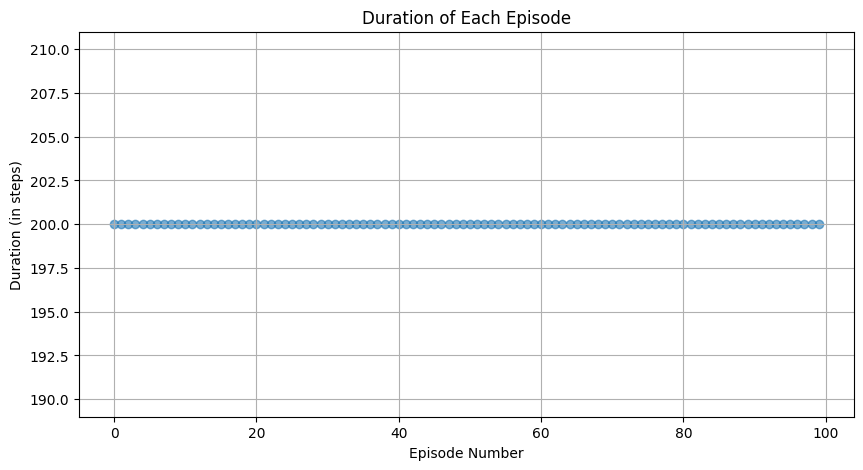

In [20]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
durations = run_multiple_episodes(random_agent, 100)
plot_episode_durations(durations)

Note from [Gymnasium Docs](https://www.gymlibrary.dev/environments/classic_control/mountain_car/#episode-end):

> The episode ends if either of the following happens:
>
> 1. **Termination:** The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
> 2. **Truncation:** The length of the episode is 200.

So it appears the episode was always truncated before the goal could be reached (i.e. random policy is bad).

## 3  DQN Agent Class

This code block describes the implementation of a DQN agent as described in task 3 of the project handout.

### 3.1 Implementation

In [2]:
# Imports for DQN agent, neural network, and replay buffer
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import time
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device {device}")

Using device cpu


In [3]:
# Define the Q-network as a MLP
class QNetwork(nn.Module):
    """
    a multi-layer perception (MLP) that takes a state s as input and outputs Q(s,a) for each
    action a

    Attributes
    ----------
    state_size:
        Number of input features, which corresponds to the dimension of the state space.
    action_size:
        Number of output features, which corresponds to the number of possible actions.
    hidden_layers:
        A list specifying the number of neurons in each hidden layer.
        Deafault is two hidden layers with 64 neurons each.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64]):
        super(QNetwork, self).__init__()
        layers = []
        input_size = state_size
        
        # Fully conected layers with ReLU activation
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, action_size))
        self.model = nn.Sequential(*layers) # Unpack list of layers into a sequential model
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, state, action, next_state, reward, done):
        self.buffer.append((state, action, next_state, reward, done))
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
class DQNAgent:
    """
    DQN agent that uses a feed-forward network to estimate Q-values
    and an epsilon-greedy policy to take actions

    Attributes
    ----------
    Q:
        Approximates the Q-values for each state-action pair using a feed-forward neural network.
    replay_buffer:
        Stores experiences as tuples and allows for random sampling to train the Q-network.
        
    Methods
    -------
    update_target_network():
        Updates the target network to match the Q-network to stabilize training.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.current_loss = None
        
        self.Q = QNetwork(state_size, action_size, hidden_layers).to(device)
        self.target_Q = QNetwork(state_size, action_size, hidden_layers).to(device)
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.update_target_network()
        
    def update_target_network(self):
        self.target_Q.load_state_dict(self.Q.state_dict())

    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        # states = torch.FloatTensor(np.array(states)).to(device)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        # Debugging
        # print(f"states shape: {states.shape}")
        # print(f"next_states shape 2: {next_states.shape}")
        # print(f"actions shape: {actions.shape}")
        
        current_q_values = self.Q(states).gather(1, actions)
        
        with torch.no_grad():
            next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss

In [6]:
# Test the DQN agent
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)

num_episodes = 10
for episode in range(num_episodes):
    # Pass integer to forcibly reset PRNG of environment according to gymnasium docs
    # secrets.randbits() generates a random integer with 64 bits
    random_integer = secrets.randbits(64)  
    state, _ = env.reset(seed=random_integer)
    done = False
    
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        dqn_agent.observe(state, action, next_state, reward, done)
        dqn_agent.update()
        
        state = next_state
        
    dqn_agent.update_target_network()
    print(f"Episode {episode + 1}/{num_episodes} finished")

/home/linuxbrew/.linuxbrew/Cellar/python@3.11/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_355/2493763466.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.FloatTensor(states).to(device)


Episode 1/10 finished
Episode 2/10 finished
Episode 3/10 finished
Episode 4/10 finished
Episode 5/10 finished
Episode 6/10 finished
Episode 7/10 finished
Episode 8/10 finished
Episode 9/10 finished
Episode 10/10 finished


### 3.2 No auxiliary reward

Train the DQNAgent for 1000 episodes and report its loss and average cumulative reward per episode.

In [48]:
def train_dqn(agent, env, num_episodes=1000):
    episode_rewards = []
    losses = []

    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        episode_loss = []

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.observe(state, action, next_state, reward, done)
            agent.update()

            cumulative_reward += reward
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)

        agent.update_target_network()
        episode_rewards.append(episode_reward)
        
        # Append average loss for this episode
        if episode_loss:
            losses.append(torch.mean(torch.stack(episode_loss)).item())
        else:
            losses.append(0)
            
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_rewards, losses

In [9]:
# Plotter functions for the results of training DQN for 1000 episodes
def plot_cumulative_rewards_loss(episode_rewards, losses):

    # Plotting results for cumulative reward
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.grid()

    # Plotting results for training loss over time
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid()

    plt.tight_layout()
    plt.show()

Episode 100/1000. Average reward: -200.00
Episode 200/1000. Average reward: -200.00
Episode 300/1000. Average reward: -200.00
Episode 400/1000. Average reward: -200.00
Episode 500/1000. Average reward: -200.00
Episode 600/1000. Average reward: -200.00
Episode 700/1000. Average reward: -200.00
Episode 800/1000. Average reward: -200.00
Episode 900/1000. Average reward: -200.00
Episode 1000/1000. Average reward: -200.00


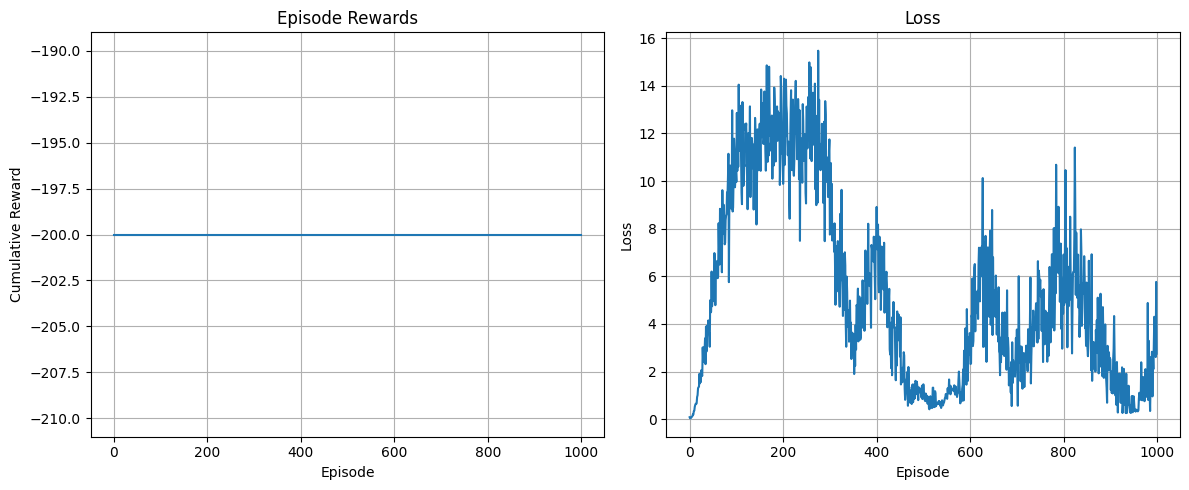

Average cumulative reward over the last 100 episodes: -200.00


In [28]:
# Train the agent
# Takes roughly 6 minutes to run
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
episode_rewards, losses = train_dqn(dqn_agent, env, num_episodes=1000)

# Plot results of training
plot_cumulative_rewards_loss(episode_rewards, losses)

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")



Does your agent solve the task?

**No, it does not.**

The main challenge of this task is the sparse reward problem discussed in the introduction. Let’s
explore ways to address this issue and help our agent to learn faster.

### 3.3 Heuristic reward function

We will now create an auxiliary reward function to assist the agent in learning better behavior. Try
to think of a reward that would help the agent solve the task. Which states location-wise should the
agent strive for?

**A possible heuristic reward is to provide positive feedback based on the agent's progress towards the goal. For example, a reward proportional to the car's position (the further right, the higher the reward).**

Note: Keep in mind that the car needs to move backwards and forwards to gain momentum.

In [7]:
def calculate_auxiliary_reward(state):
    """
    Simple auxiliary reward proportional to the car's position.
    
    Note that the position takes values between -1.2 and +0.6 in the MountainCar environment.
    Thus, it is highest when the car is closest to the flag.
    """
    position = state[0]
    return position

In [8]:
def train_dqn_with_auxiliary_reward(agent, env, num_episodes=3000, test=False):
    episode_durations = []
    episode_rewards = []
    episode_auxiliary_rewards = []
    episode_total_rewards = []
    successes = 0
    cumulative_successes = []
    losses = []
    
    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        cumulative_auxiliary_reward = 0
        episode_loss = []
        steps = 0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Calculate auxiliary reward
            auxiliary_reward = calculate_auxiliary_reward(next_state)
            total_reward = reward + auxiliary_reward
            
            if not test:
                agent.observe(state, action, next_state, total_reward, done)
                agent.update()
            
            cumulative_reward += reward
            cumulative_auxiliary_reward += auxiliary_reward
            steps += 1
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_auxiliary_rewards.append(cumulative_auxiliary_reward)
        episode_total_rewards.append(cumulative_reward + cumulative_auxiliary_reward)
        
        if terminated and not truncated:
            successes += 1
        
        cumulative_successes.append(successes)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_total_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
        # Append average loss for this episode
        if episode_loss:
            losses.append(torch.mean(torch.stack(episode_loss)).item())
        else:
            losses.append(0)
            
    return episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes, losses

In [9]:
def plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes):
    # Plotting results
    plt.figure(figsize=(18, 12))

    # Episode durations
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration (steps)')
    plt.grid()

    # Rewards
    plt.subplot(2, 2, 2)
    plt.plot(episode_rewards, label='Environment Reward')
    plt.plot(episode_auxiliary_rewards, label='Auxiliary Reward')
    plt.plot(episode_total_rewards, label='Total Reward')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()

    # Cumulative rewards
    plt.subplot(2, 2, 3)
    cumulative_env_rewards = np.cumsum(episode_rewards)
    cumulative_aux_rewards = np.cumsum(episode_auxiliary_rewards)
    cumulative_total_rewards = np.cumsum(episode_total_rewards)
    plt.plot(cumulative_env_rewards, label='Cumulative Environment Reward')
    plt.plot(cumulative_aux_rewards, label='Cumulative Auxiliary Reward')
    plt.plot(cumulative_total_rewards, label='Cumulative Total Reward')
    plt.title('Cumulative Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid()

    # Cumulative number of successes
    plt.subplot(2, 2, 4)
    plt.plot(cumulative_successes)
    plt.title('Cumulative Number of Successes')
    plt.xlabel('Episode')
    plt.ylabel('Number of Successes')
    plt.grid()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_loss_only(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

Episode 100/3000. Average reward: -283.59
Episode 200/3000. Average reward: -271.83
Episode 300/3000. Average reward: -221.20
Episode 400/3000. Average reward: -192.84
Episode 500/3000. Average reward: -204.51
Episode 600/3000. Average reward: -204.26
Episode 700/3000. Average reward: -190.41
Episode 800/3000. Average reward: -190.96
Episode 900/3000. Average reward: -182.15
Episode 1000/3000. Average reward: -178.90
Episode 1100/3000. Average reward: -178.33
Episode 1200/3000. Average reward: -183.63
Episode 1300/3000. Average reward: -191.26
Episode 1400/3000. Average reward: -203.34
Episode 1500/3000. Average reward: -198.58
Episode 1600/3000. Average reward: -175.23
Episode 1700/3000. Average reward: -163.62
Episode 1800/3000. Average reward: -195.39
Episode 1900/3000. Average reward: -211.66
Episode 2000/3000. Average reward: -197.19
Episode 2100/3000. Average reward: -182.43
Episode 2200/3000. Average reward: -181.81
Episode 2300/3000. Average reward: -179.36
Episode 2400/3000. A

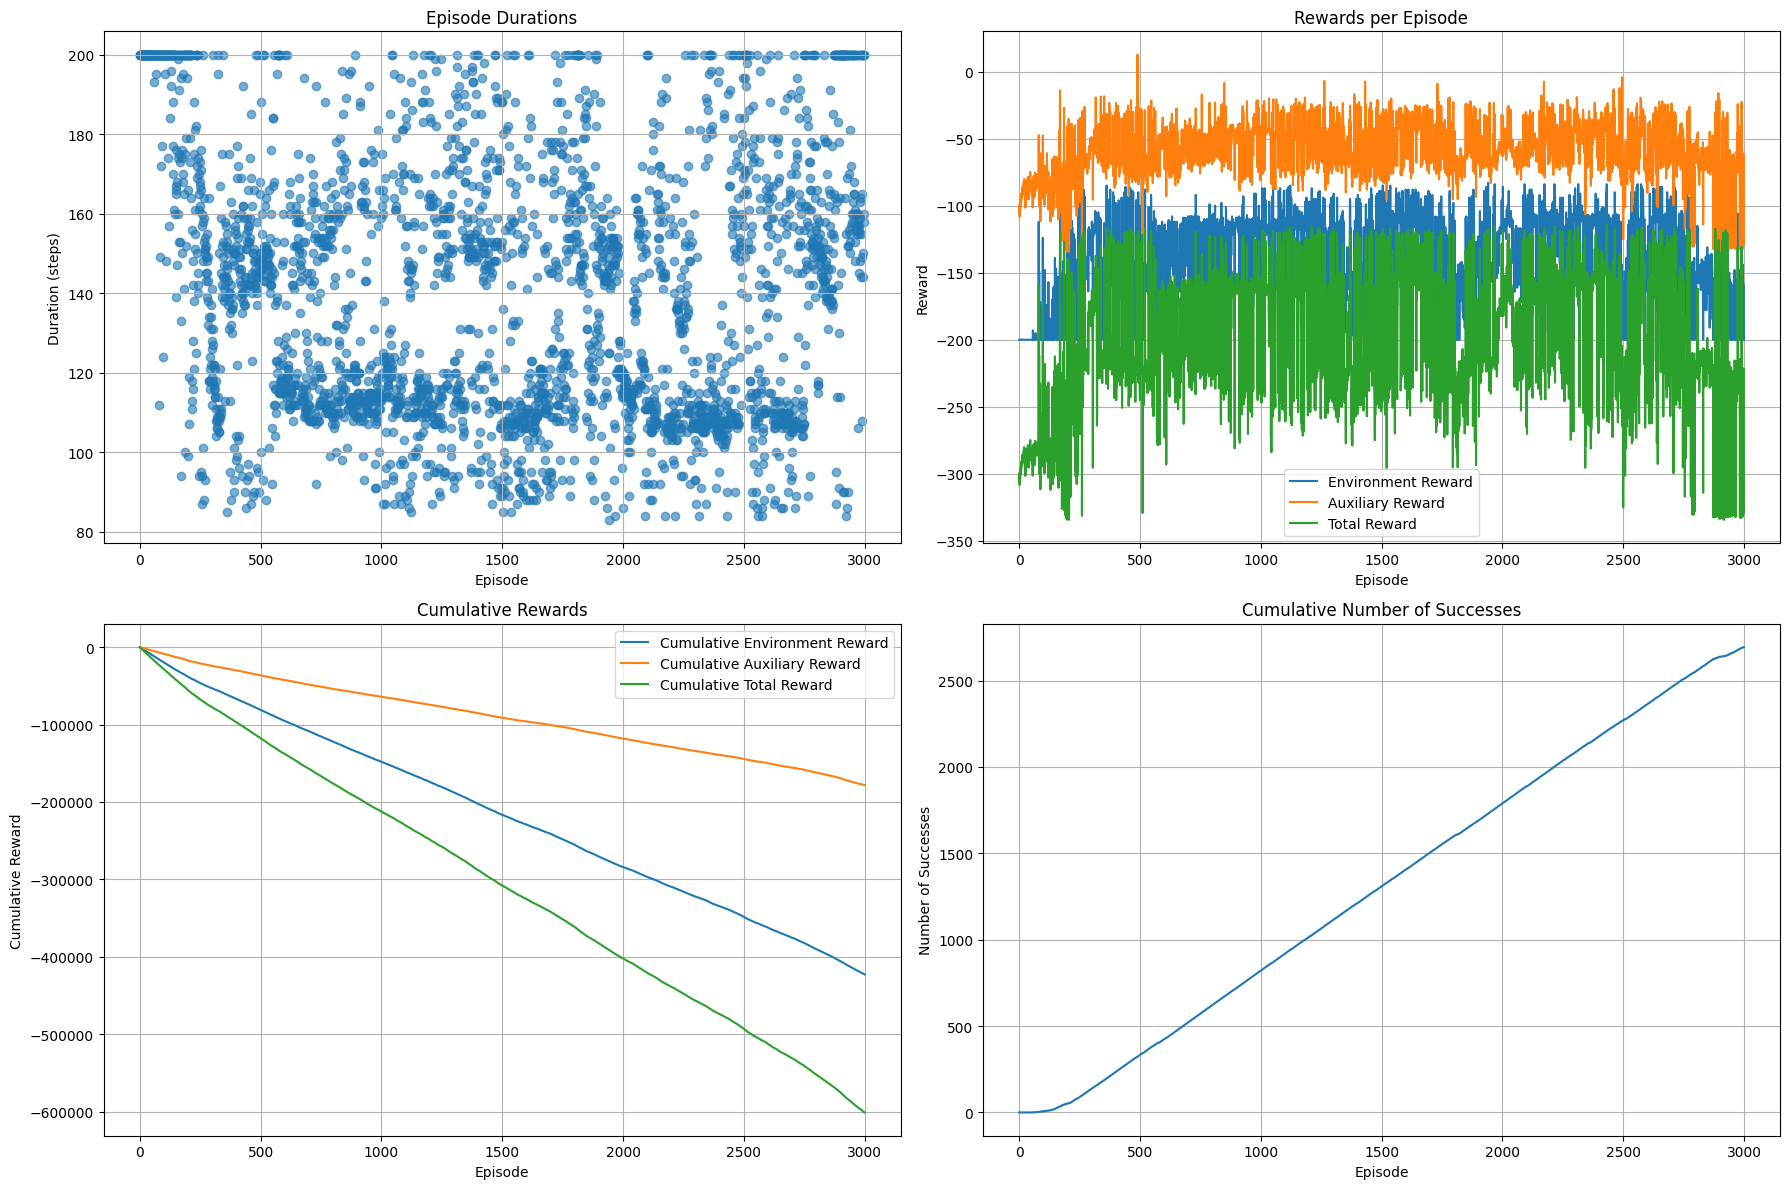

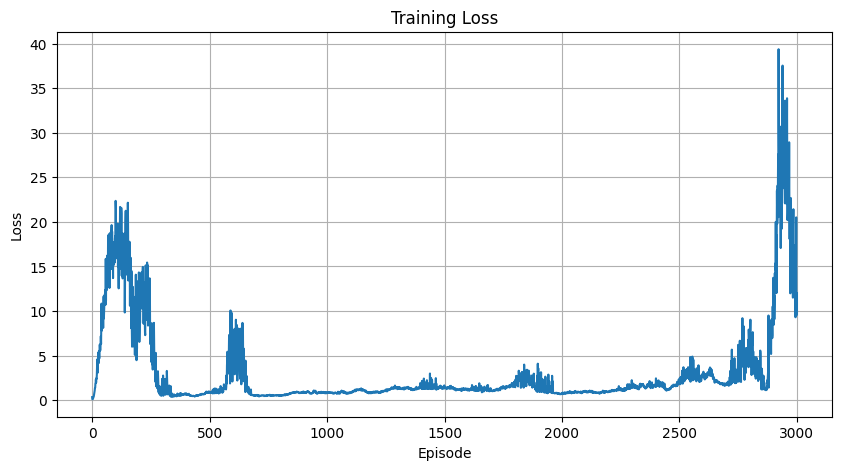

Average cumulative reward over the last 100 episodes: -262.18


In [11]:
# Train the agent with auxiliary reward
# Takes 15-20 minutes to run
dqn_agent = DQNAgent(state_size, action_size)
episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, \
    cumulative_successes, losses = train_dqn_with_auxiliary_reward(dqn_agent, env, num_episodes=3000)

# Plot results of training
plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes)
plot_loss_only(losses)

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")

Does it successfully solve the task?
What happens if you choose very small/very large auxiliary rewards?

Experiment with the parameters of your auxiliary reward to improve the performance. With a good set of parameters, it should solve the task in less than a thousand episodes.

### 3.4 Non domain-specific reward

Implementation of Random Network Distillation (RND) [Burda et al.](https://arxiv.org/pdf/1810.12894).

Consisting of:
- **Target Network** with fixed ranodom weights. Input: State, Output: Single Number.
- **Predictor Network** with adaptable weights. Input: State, Output: Single Number.

In [9]:
class RNDNetwork(nn.Module):
    def __init__(self, input_dim):
        super(RNDNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [10]:
class DQNAgent_RND(DQNAgent):
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001, reward_factor=0.1):
        super().__init__(state_size, action_size, hidden_layers, gamma, epsilon,
                         epsilon_min, epsilon_decay, replay_buffer_size, batch_size, lr)
        self.reward_factor = reward_factor
        self.predictor = RNDNetwork(state_size).to(device)
        self.target = RNDNetwork(state_size).to(device)
        self.rnd_optimizer = torch.optim.Adam(self.predictor.parameters(), lr=lr)
        
        self.state_mean = np.zeros(state_size)
        self.state_var = np.ones(state_size)
        self.rnd_mean = 0
        self.rnd_var = 1
        self.steps = 0
    
    def update_normalization_stats(self, state):
        self.steps += 1
        alpha = 1.0 / self.steps
        self.state_mean = (1 - alpha) * self.state_mean + alpha * state
        self.state_var = (1 - alpha) * self.state_var + alpha * (state - self.state_mean) ** 2
        
    def normalize_state(self, state):
        return (state - self.state_mean) / (np.sqrt(self.state_var) + 1e-8)
    
    def compute_rnd_reward(self, next_states):
        # Handle batach of next states
        # normalized_states = torch.FloatTensor(np.array([self.normalize_state(s) for s in next_states])).to(device) # Batch normalization
        normalized_states = np.array([self.normalize_state(s) for s in next_states])  # Batch normalization
        normalized_states = torch.FloatTensor(normalized_states).to(device)
        
        with torch.no_grad():
            target_outputs = self.target(normalized_states)
        predictor_outputs = self.predictor(normalized_states)
        
        rnd_errors = (predictor_outputs - target_outputs).pow(2).mean(dim=1).detach().cpu().numpy()
        
        alpha = 1.0 / max(1, self.steps - 100) # Start normalizing after 100 steps
        self.rnd_mean = (1 - alpha) * self.rnd_mean + alpha * rnd_errors.mean()
        self.rnd_var = (1 - alpha) * self.rnd_var + alpha * ((rnd_errors - self.rnd_mean) ** 2).mean()
        
        normalized_rnd_errors = (rnd_errors - self.rnd_mean) / (np.sqrt(self.rnd_var) + 1e-8)
        rnd_rewards = np.clip(normalized_rnd_errors, -5, 5)
        
        return rnd_rewards.tolist() # Return as list to handle batch processing
    
    def update_predictor(self, states):
        self.rnd_optimizer.zero_grad()
        # normalized_states = torch.FloatTensor(np.array([self.normalize_state(s) for s in states])).to(device)  # Handling batch normalization
        normalized_states = np.array([self.normalize_state(s) for s in states])  # Handling batch normalization
        normalized_states = torch.FloatTensor(normalized_states).to(device)
        
        with torch.no_grad():
            target_outputs = self.target(normalized_states)
        predictor_outputs = self.predictor(normalized_states)
        
        loss = nn.MSELoss()(predictor_outputs, target_outputs)
        loss.backward()
        self.rnd_optimizer.step()
        
        return loss.item()
    
    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)
        self.update_normalization_stats(next_state)
        
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        # states = torch.FloatTensor(np.array(states)).to(device) # Should be faster but isn't
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        # Vectorized RND reward computation
        rnd_rewards = torch.FloatTensor(self.compute_rnd_reward(next_states)).unsqueeze(1).to(device)
        total_rewards = rewards + self.reward_factor * rnd_rewards
        
        # Compute Q-Values
        current_q_values = self.Q(states).gather(1, actions)
        
        with  torch.no_grad():
            next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
            target_q_values = total_rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss.item()
        
        # Batched RND updates
        self.update_predictor(next_states)
            
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()
        
                

In [11]:
def train_dqn_rnd(agent, env, num_episodes=100, test=False):
    episode_durations = []
    episode_rewards = []
    episode_rnd_rewards = []
    episode_total_rewards = []
    cumulative_successes = []
    successes = 0
    losses = []
    
    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        cumulative_rnd_reward = 0
        steps = 0
        episode_loss = []
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            rnd_reward = agent.compute_rnd_reward([next_state])[0]  # Ensure it handles single next_state correctly
            total_reward = reward + agent.reward_factor * rnd_reward
            
            if not test:
                agent.observe(state, action, next_state, total_reward, done)
                agent.update()
            
            cumulative_reward += reward
            cumulative_rnd_reward += rnd_reward
            state = next_state
            steps += 1
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_rnd_rewards.append(cumulative_rnd_reward)
        episode_total_rewards.append(cumulative_reward + agent.reward_factor * cumulative_rnd_reward)
        
        if terminated and not truncated:
            successes += 1
            
        cumulative_successes.append(successes)
        
        # Append average loss for this episode
        if episode_loss:
            episode_loss_tensors = [torch.tensor(loss) if not isinstance(loss, torch.Tensor) else loss for loss in episode_loss]
            losses.append(torch.mean(torch.stack(episode_loss_tensors)).item())
        else:
            losses.append(0)
            
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_total_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses

Train the agent with RND reward and plot results.

In [60]:
# Takes 65-70 minutes to run for 100 episodes (Marc)
# Takes 5 minutes to run for 100 episodes (Romino)
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_rnd_agent = DQNAgent_RND(state_size, action_size)
episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses = \
    train_dqn_rnd(dqn_rnd_agent, env, num_episodes=3000)

Episode 100/3000. Average reward: -196.46
Episode 200/3000. Average reward: -152.16
Episode 300/3000. Average reward: -128.78
Episode 400/3000. Average reward: -145.39
Episode 500/3000. Average reward: -146.34
Episode 600/3000. Average reward: -144.66
Episode 700/3000. Average reward: -135.07
Episode 800/3000. Average reward: -123.90
Episode 900/3000. Average reward: -135.87
Episode 1000/3000. Average reward: -147.52
Episode 1100/3000. Average reward: -137.58
Episode 1200/3000. Average reward: -138.06
Episode 1300/3000. Average reward: -126.45
Episode 1400/3000. Average reward: -144.50
Episode 1500/3000. Average reward: -148.15
Episode 1600/3000. Average reward: -124.37
Episode 1700/3000. Average reward: -129.33
Episode 1800/3000. Average reward: -134.27
Episode 1900/3000. Average reward: -153.69
Episode 2000/3000. Average reward: -127.64
Episode 2100/3000. Average reward: -147.68
Episode 2200/3000. Average reward: -159.51
Episode 2300/3000. Average reward: -142.37
Episode 2400/3000. A

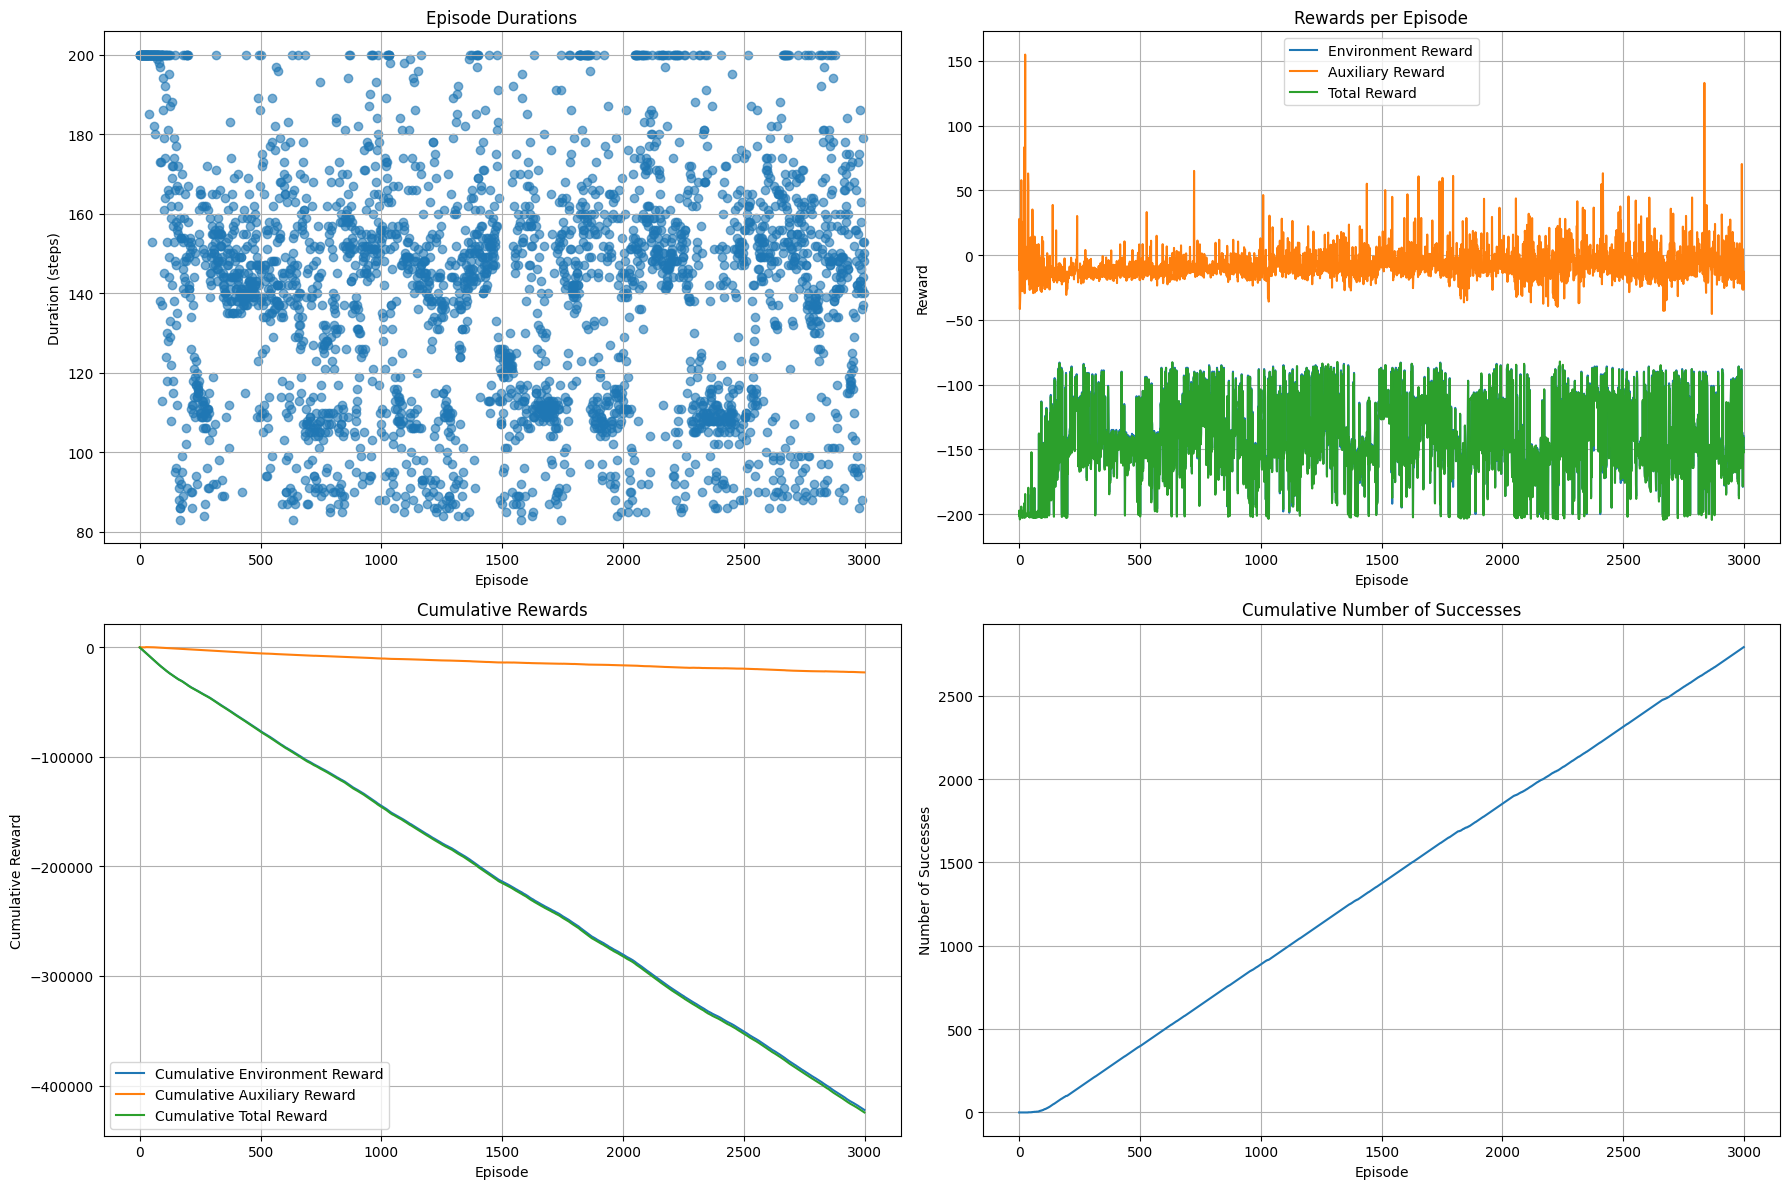

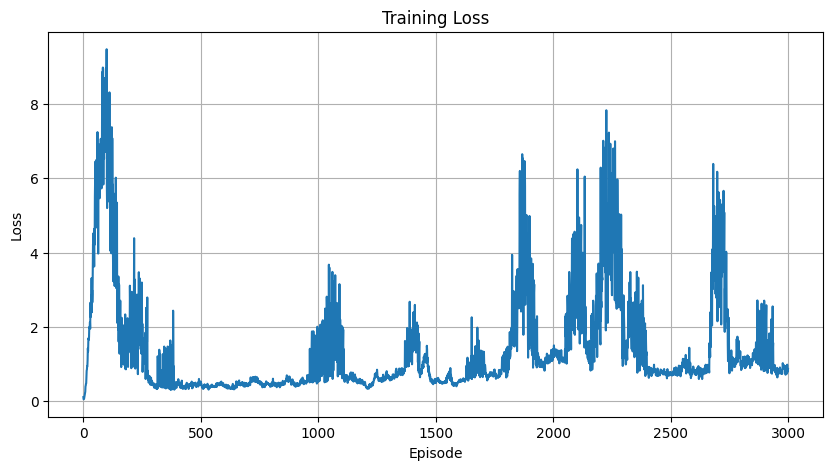

Average cumulative reward over the last 10 episodes: -141.67


In [61]:
# Plot results of training
plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes)
plot_loss_only(losses)

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-100:])
print(f"Average cumulative reward over the last 10 episodes: {average_cumulative_reward:.2f}")

## Dyna Agent Class

#### This code block describes the implementation of a Dyna agent as described in task 4 of the project handout.

### 4.1 State Discretization, 4.2 Model Building & 4.3 Implementation

In [14]:
class DynaAgent:
    def __init__(self,  environment, discr_step=np.array([0.025, 0.005]), gamma=0.99, epsilon=0.9, epsilon_min=0.05, 
                 epsilon_decay=0.995, k=10, number_of_episodes=10, test=False):
        
        # Initialize attributes that can be passed as simple parameters
        self.discr_step = discr_step
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.k = k
        self.number_of_episodes = number_of_episodes
        self.environment = environment
        self.test = test

        # Perform discretization of the state space and store it with the agent object using simple numpy functions
        self.discrete_positions = np.arange(start=environment.observation_space.low[0], stop=environment.observation_space.high[0], step=discr_step[0])
        self.discrete_velocities = np.arange(start=environment.observation_space.low[1], stop=environment.observation_space.high[1], step=discr_step[1])

        # Store the number of discrete states as well as the number of actions in separate attributes
        self.n_states = self.discrete_positions.size * self.discrete_velocities.size
        self.n_actions = environment.action_space.n

        # Initialize complex attributes and adjust dependent attributes based on passed parameters
        self.P_hat = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        self.P_hat[:, :, :] = np.full(shape=self.n_states, fill_value=(1/self.n_states))
        self.R_hat = np.zeros(shape=(self.n_states, self.n_actions))
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))

        # Initialize helper attributes for updating the model view of the agent
        self.visit_counts = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        self.cumulative_returns = np.zeros(shape=(self.n_states, self.n_actions))

        # Store a list keeping track of previously encountered state-action pairs
        self.state_action_buffer = []
    
    def discretize_state(self, state):

        posi, velo = state

        # Performs discretization by rounding down the continuous state value to the adjacent lower discrete state value
        posiIndex = np.digitize(posi, self.discrete_positions) - 1
        veloIndex = np.digitize(velo, self.discrete_velocities) - 1

        # Returns the logical index of the discretized state in our data structures of size n_states
        return posiIndex * self.discrete_velocities.size + veloIndex, posiIndex, veloIndex

        
    def observe(self, state, action, next_state, reward):

        # Perform the 4 states outlined in the handout

        # Step 1: Discretize the obtained states s and s'

        # Note that the state indices are returned by the function
        state_s_index, posIdx,  velIdx = self.discretize_state(state)
        state_sPrime_index, _, _ = self.discretize_state(next_state)

        # Record visited state-action pairs in our buffer structure
        # Note that we store the index of the visited state as it enables more lightweight coding
        self.state_action_buffer.append((state_s_index, action, posIdx, velIdx))

        # Step 2: Update the model of the transition probabilities and the expected reward

        self.visit_counts[state_s_index][action][state_sPrime_index] += 1
        self.cumulative_returns[state_s_index][action] += reward

        self.P_hat[state_s_index][action] = self.visit_counts[state_s_index][action] / np.sum(self.visit_counts[state_s_index][action])
        self.R_hat[state_s_index][action] = self.cumulative_returns[state_s_index][action] / np.sum(self.visit_counts[state_s_index][action])

        # Step 3: Update the Q-value at state s according to the formula on the handout

        # Perform the actual Q-value update
        term = np.dot(self.P_hat[state_s_index][action], np.max(self.Q, axis=1))
        self.Q[state_s_index][action] = self.R_hat[state_s_index][action] + (self.gamma * term)

        # Store the value by which the Q-value at state s is updated and return it for plotting later
        retVal = self.Q[state_s_index][action]

        # Step 4: Perform k further Q-value updates for randomly chosen state-action pairs that were already encountered

        for _ in range(self.k):

            # Randomly choose an already encountered state-action pair
            idx, act, _, _= random.choice(self.state_action_buffer)

            # Now perform the actual update of the Q-value as in Step 3
            term = np.dot(self.P_hat[idx][act], np.max(self.Q, axis=1))
            self.Q[idx][act] = self.R_hat[idx][act] + (self.gamma * term)

        return retVal

    def select_action(self, state):

        # Pick an action from the given state according to epsilon greedy policy on the Q-values

        if np.random.rand() <= self.epsilon:
            return self.environment.action_space.sample()
        else:
            discreteState, _, _ = self.discretize_state(state)
            valsQ = self.Q[discreteState]
            return np.argmax(valsQ)

    def update(self):

        # Metrics for plotting
        episode_durations = []
        episode_rewards = []
        successes = 0
        cumulative_successes = []
        qValue_updates = []

        # Runs the training procedure

        for episode in range(self.number_of_episodes):
            random_integer = secrets.randbits(64)  
            state, _ = self.environment.reset(seed=random_integer)
            done = False
            cumulative_reward = 0
            episode_length = 0
            episode_q = []

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.environment.step(action)
                done = terminated or truncated

                # Updated Q-value for plotting
                # If in test mode, skip this update step
                if self.test:
                    qNew = 0
                else:
                    qNew = self.observe(state, action, next_state, reward)

                # Remember to adjust the epsilon value to decay in training
                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

                state = next_state

                # Update metrics used for plotting later on
                cumulative_reward += reward
                episode_q.append(qNew)
                episode_length += 1

            # Update metrics used for plotting later on
            episode_durations.append(episode_length)
            episode_rewards.append(cumulative_reward)

            if terminated and not truncated:
                successes += 1
            
            cumulative_successes.append(successes)

            qValue_updates.append(np.mean(np.array(episode_q)))

            # Used for debugging
            #if (episode + 1) % 100 == 0:
                #print(f"Episode {episode + 1}/{self.number_of_episodes} finished with length {episode_length}")
        
        return episode_durations, episode_rewards, cumulative_successes, qValue_updates

### 4.4 Results

#### We first run the DynaAgent with no auxiliary reward for 3000 episodes.

Training with k = 0 took 49.23326325416565 seconds.


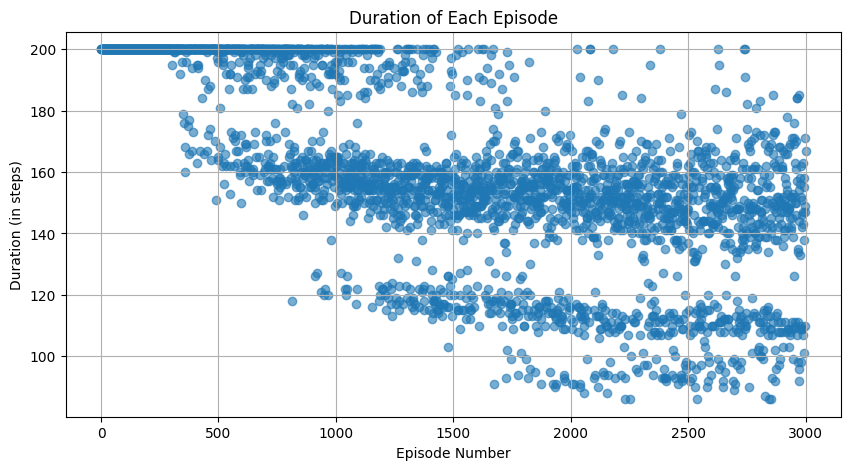

Training with k = 1 took 75.7269012928009 seconds.


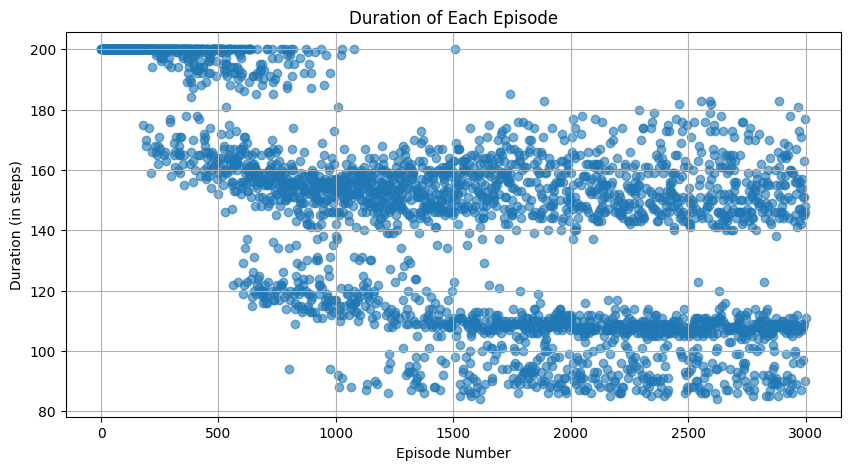

Training with k = 5 took 172.12569284439087 seconds.


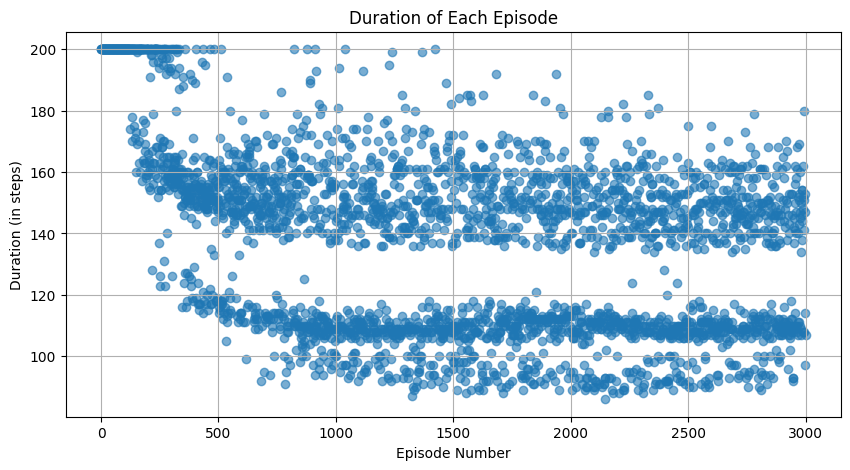

Training with k = 10 took 295.07635259628296 seconds.


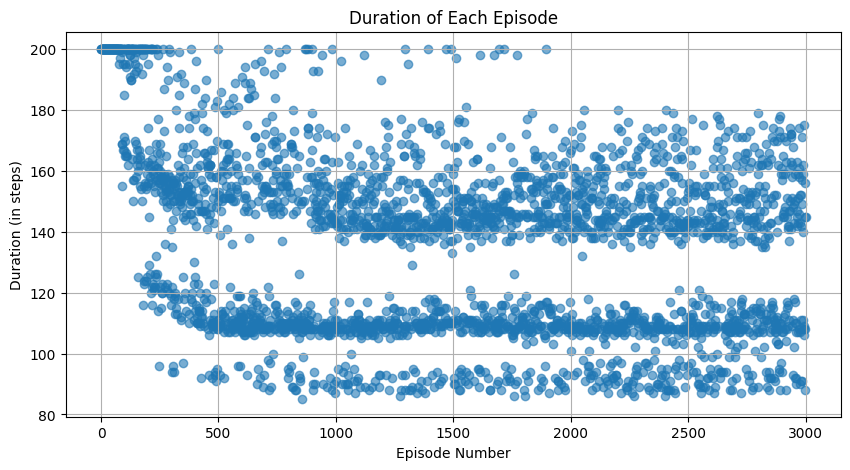

Training with k = 20 took 559.5026607513428 seconds.


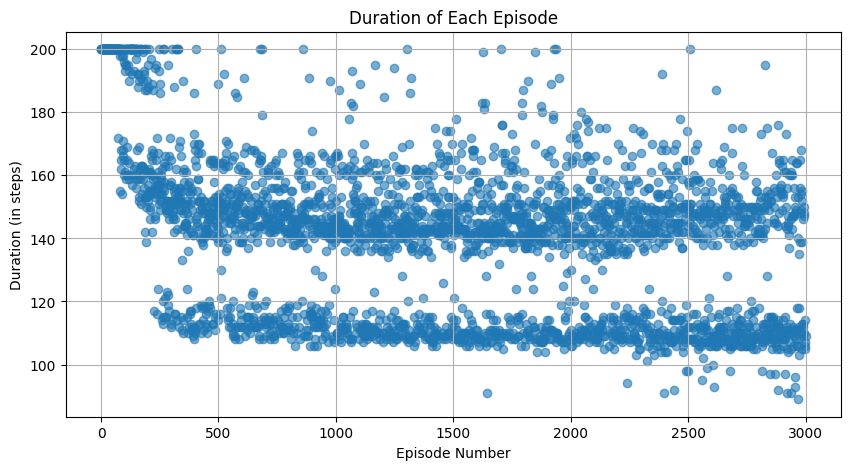

In [10]:
# We run the agent with different values for k
# Running the cell roughly takes 20 minutes
env = gym.make("MountainCar-v0")
for val in [0, 1, 5, 10, 20]:
    agent = DynaAgent(env, k=val, number_of_episodes=3000)
    start = time.time()
    durations, _, _, _ = agent.update()
    end = time.time()
    print(f"Training with k = {val} took {end - start} seconds.")
    plot_episode_durations(durations)

##### Question: Does it solve the task?
Yes it does, as one can infer from the length of the episodes going down indicating success. Moreover, the agent succeeds regardless of the value of k. It is important to note though that the agent becomes more successful for larger values of k on the one hand, whilst its runtime suffers on the other (since more Q-value updates are performed, this shouldn't be surprising). This is an important trade-off to consider when solving the problem at hand using our DynaAgent class.

Please note that the benefit of increasing k in contrast to the extended runtime starts to fade away. Hence, we continue to use k=10 for the scenarios to follow.

#### We now play with different discretization steps as instructed in the handout.

Training with discr_step = [0.0125 0.0025] took 1053.1063351631165 seconds.


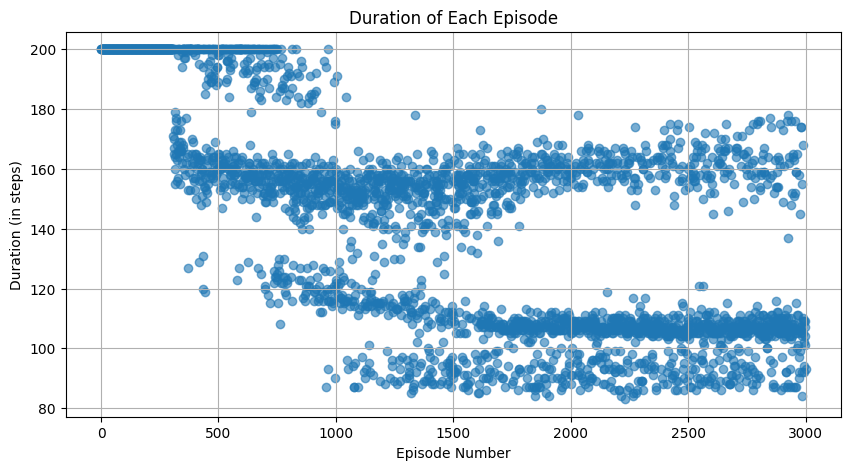

Training with discr_step = [0.0175  0.00375] took 559.8968501091003 seconds.


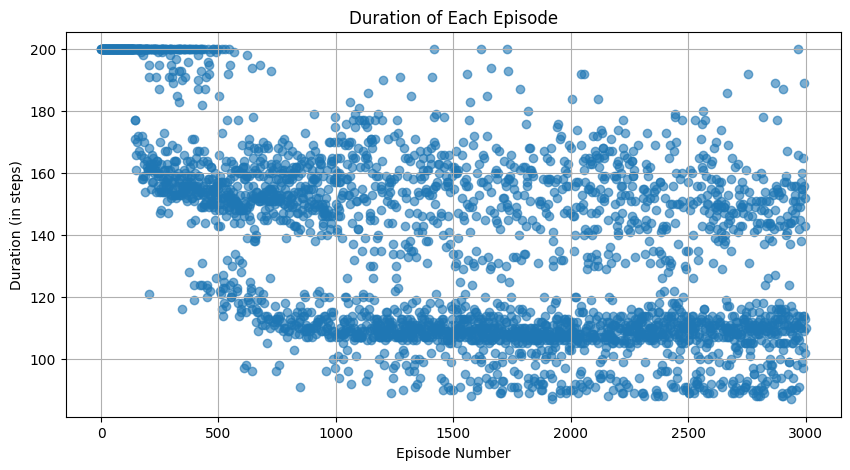

Training with discr_step = [0.025 0.005] took 317.45333099365234 seconds.


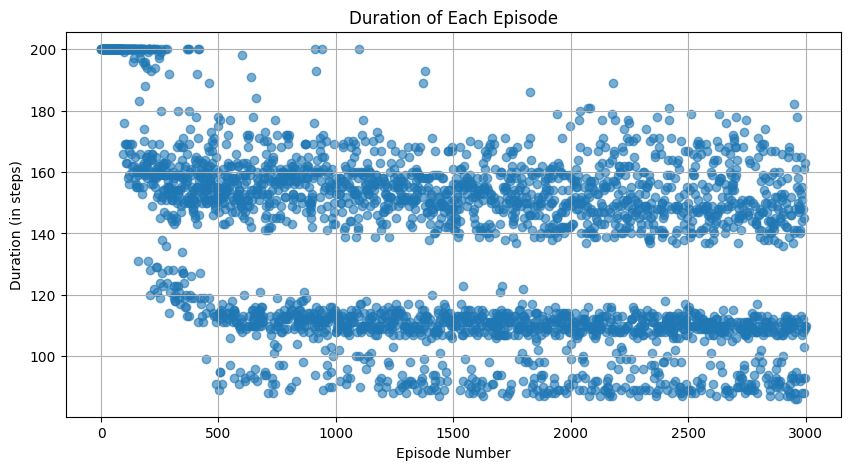

Training with discr_step = [0.05 0.01] took 122.28800010681152 seconds.


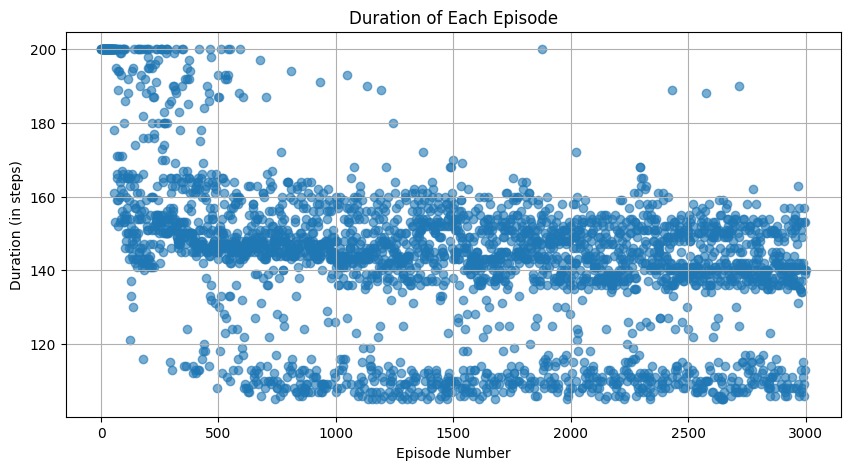

Training with discr_step = [0.1  0.02] took 80.30836915969849 seconds.


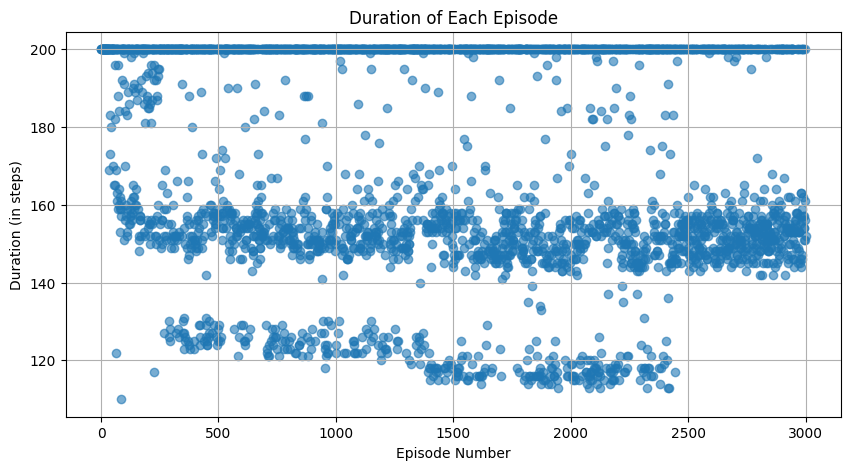

Training with discr_step = [0.2  0.04] took 66.47170948982239 seconds.


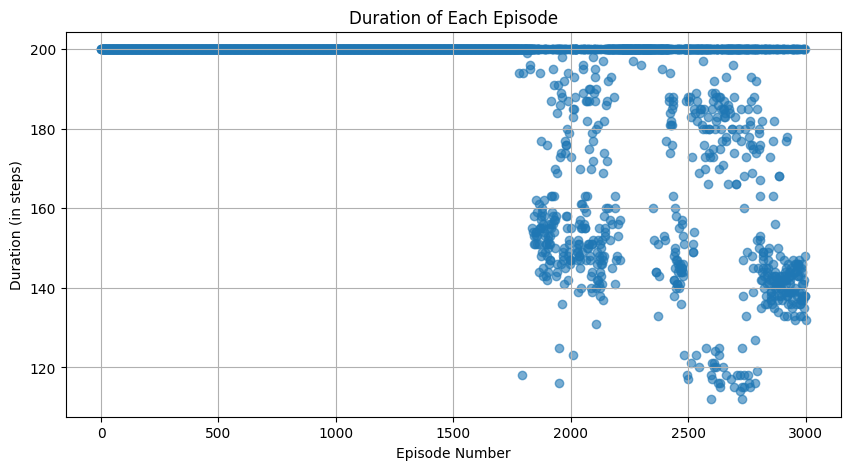

In [14]:
# From now on, we use k = 10 as our default value since it balances performance and runtime rather well.
# Running the cell roughly takes 37 minutes
env = gym.make("MountainCar-v0")
for steps in [[0.0125, 0.0025], [0.0175, 0.00375], [0.025, 0.005], [0.05, 0.01], [0.1, 0.02], [0.2, 0.04]]:
    passed = np.array(steps)
    agent = DynaAgent(env, discr_step=passed, number_of_episodes=3000)
    start = time.time()
    durations, _, _, _ = agent.update()
    end = time.time()
    print(f"Training with discr_step = {passed} took {end - start} seconds.")
    plot_episode_durations(durations)

##### Question: What happens if you use overly large bins? On the other hand, why would we refrain from using too small bins? Give an intuitive explanation, backed up by experimental results.
If overly large bins are used, then the agent's performance gradually decreases as a result of the increased bin size. This stems from the fact that the large bins do not accurately approximate the continuous environment anymore at some point, leading the agent to not learn the environment representation properly and failing to find a suitable solution to the problem. Nevertheless, a larger bin size can speed up training as the state space becomes smaller.

Using too small bins on the other hand can help approximate the continuous landscape better by providing more accurate samples. However, it becomes very resource heavy in terms of memory being used (using the step sizes [0.00625, 0.00125] even failed due to memory constraints on one of the group member's machine) as well as in terms of the time needed to perform training as one can also see in our experimental results. Furthermore, our experimental runs also show that using smaller bins did not necessarily boost performance by a lot if even at all.

#### We rerun training with our fixed k = 10 and generate the same plots as for DQN training. Instead of the training loss, we plot the Q-value update set instead.

In [17]:
# Define a new function to plot the Q-value update step instead of the training loss as for the DQN agents
def plot_qValue_update(inputQVals):
    # Plot Q-value update step
    plt.figure(figsize=(10, 5))
    plt.plot(inputQVals)
    plt.title('Q-value Update Steps')
    plt.xlabel('Episode')
    plt.ylabel('Mean Q-value updates')
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 5))

In [18]:
def plot_dyna_stats(episode_durations, episode_rewards, cumulative_successes):
    # Plotting results
    plt.figure(figsize=(18, 12))

    # Episode durations
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration (steps)')
    plt.grid()

    # Rewards
    plt.subplot(2, 2, 2)
    plt.plot(episode_rewards, label='Total Reward')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()

    # Cumulative rewards
    plt.subplot(2, 2, 3)
    cumulative_total_rewards = np.cumsum(episode_rewards)
    plt.plot(cumulative_total_rewards, label='Cumulative Total Reward')
    plt.title('Cumulative Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid()

    # Cumulative number of successes
    plt.subplot(2, 2, 4)
    plt.plot(cumulative_successes)
    plt.title('Cumulative Number of Successes')
    plt.xlabel('Episode')
    plt.ylabel('Number of Successes')
    plt.grid()

    plt.tight_layout()
    plt.show()

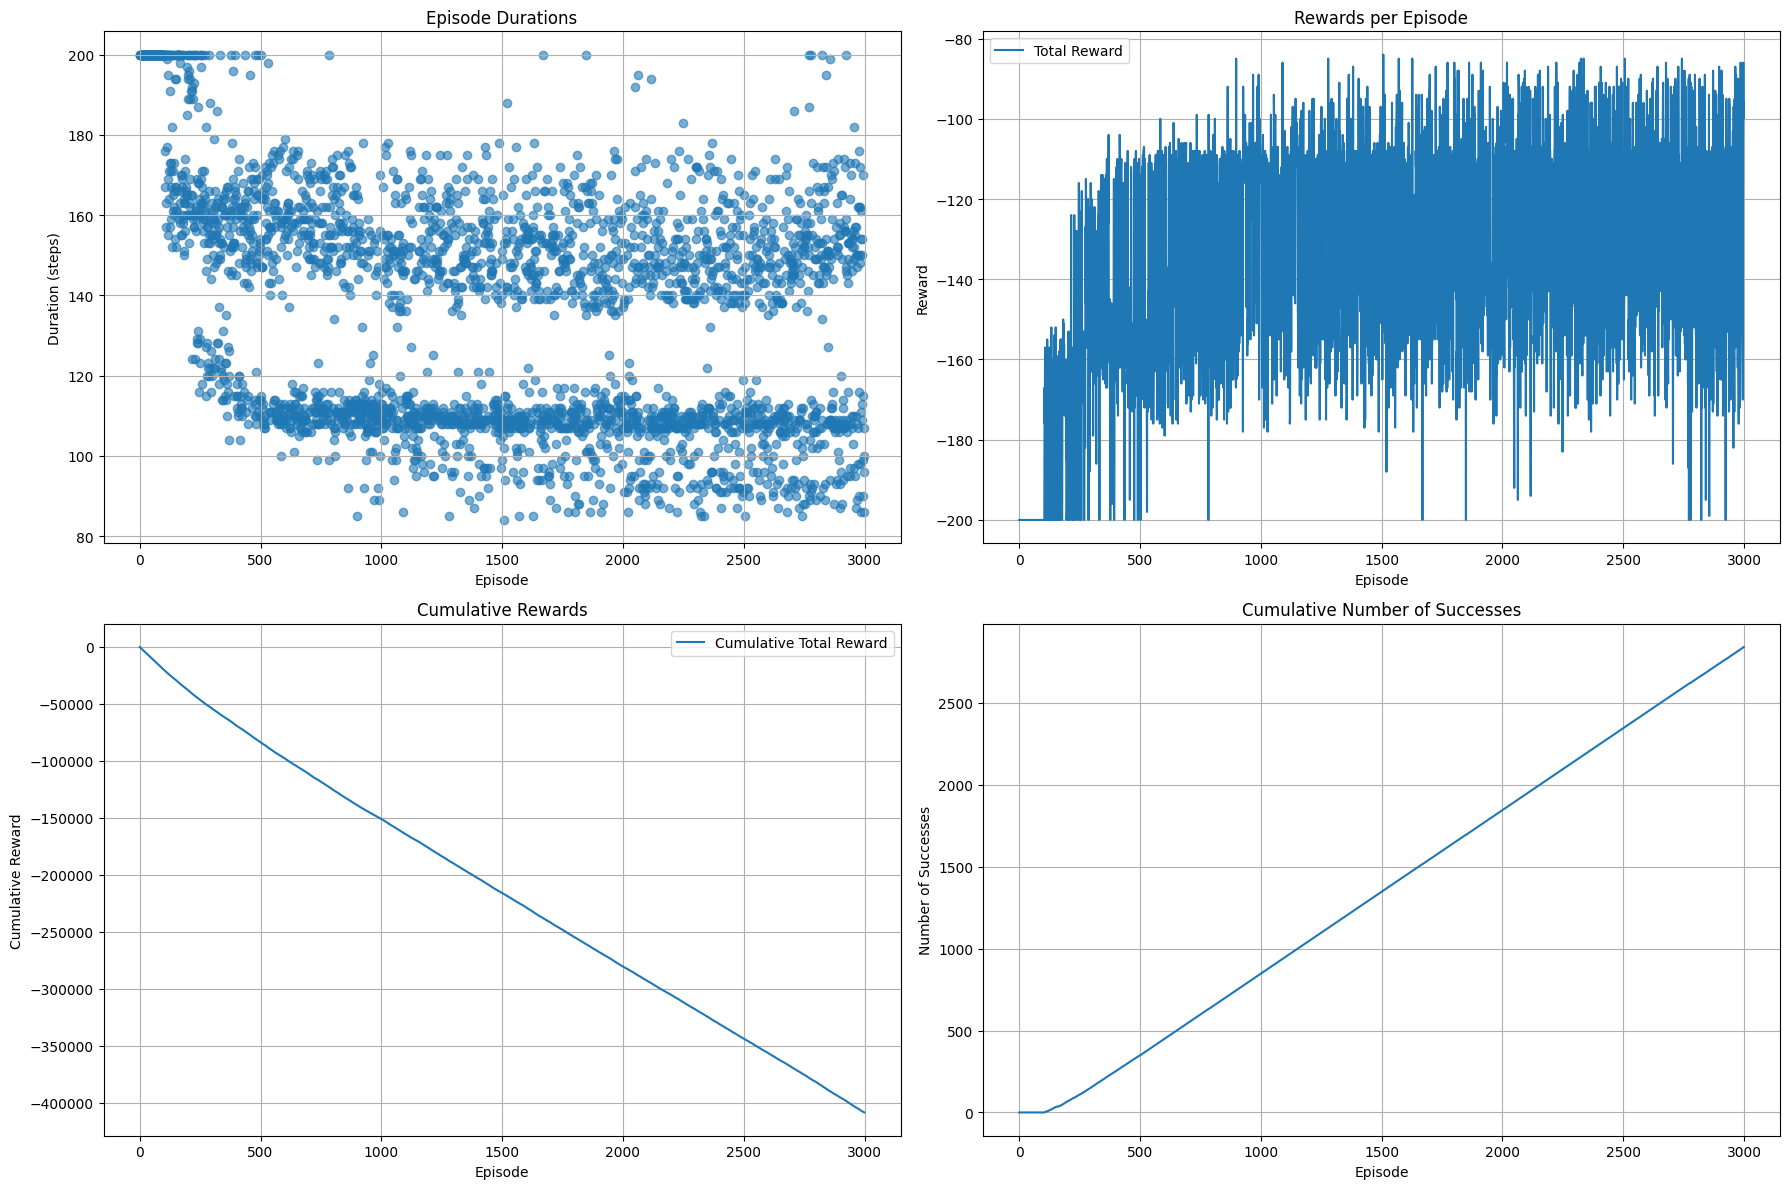

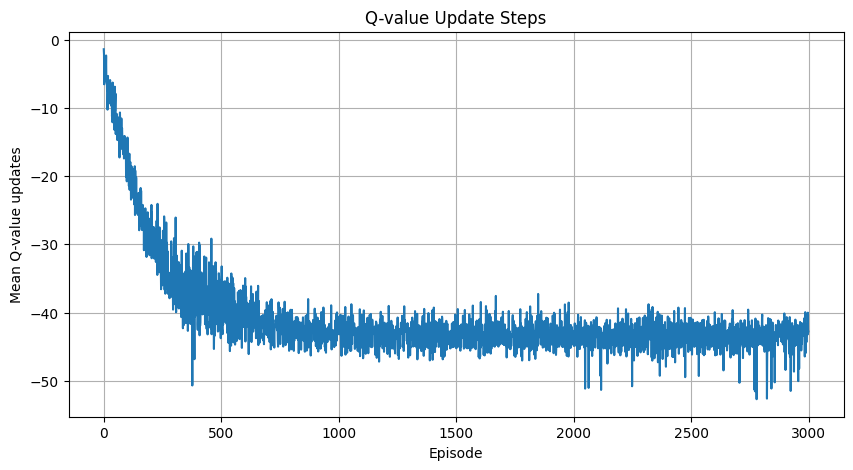

<Figure size 1000x500 with 0 Axes>

In [19]:
# Here, we rerun training to generate the required plots
# Running the cell roughly takes 5 minutes
env = gym.make("MountainCar-v0")
agent = DynaAgent(env, number_of_episodes=3000)
durations, rewards, successes, q_updates  = agent.update()
plot_dyna_stats(durations, rewards, successes)
plot_qValue_update(q_updates)

##### Question: Comment on trends observed in the plots
From the episode durations and rewards per episode plot, we can observe quite easily that the agent is able to solve the challenge at hand rather consistenly after training for approximately 250-300 epochs. This might stem from our exploration policy fading out by the schedule with which we decrease epsilon on one hand, as well as the environment model becoming sufficiently strong to indicate efficient strategy establishment on the other.

Furthermore, the cumulative rewards plot and the cumulative successes plot start to descrease and increase proportionally to the number of episodes after the previously identified cutoff, indicating stability and success of our learned policy which is what we've identified before.

Finally, the plot showing the mean Q-value update steps shows that the updates start to converge roughly after episode 500 which indicates that the agent starts to consistently solve the task as can also be identified when looking at the other plots. Moreover, our previously identified turning point at around episode 250-300 is reflected too in the fact the the mean updates stop changing by a lot hinting at the agent starting to settle at a suitable policy. This supports our other observations since we say that after this point, the agent start to solve the task successfully.

##### Question: Why does Dyna solve the task even without auxiliary reward?
We observed in 3.2 that DQN without any auxiliary reward did not solve the task due to the sparse reward environment not providing much useful feedback inherently. When choosing auxiliary rewards however, such as position information and its closeness to the target, the agent learned to reach those consequently and also started to solve the task.

In this case with Dyna, efficiently combine real and simulated learning experiences, where we start of with efficient exploration up until roughly episodes 250-300, as identified earlier, followed by exploitation which both are based on our good updates to the epsilon-greedy policy. Moreover, learning in general also profits from the model-based component of Dyna with which we estimate expected rewards and state transition probabilities effectively of our environment. The model of the environment can especially benefit from our exploration part.

In conclusion, one might say that Dyna combines the best of both worlds, where we mean the combination of the positive effects of direct environment interaction and model-based information for simulated experiences. This in total speeds up training so to say and overcomes the issue of a sparse reward space by leveraging the construction of a model of the problem at hand. Additionally, the fact that we discretize the continuous state space through which information can be lost (as shown we talking about bin sizes) seems to be made up for by Dyna's advantages when the bin sizes are suitable.

#### We rerun training with our fixed k = 10 and generate the episode duration plot multiple times for ever increasing values of the number of episodes.

Training with #episodes = 1500 took 174.79512667655945 seconds.


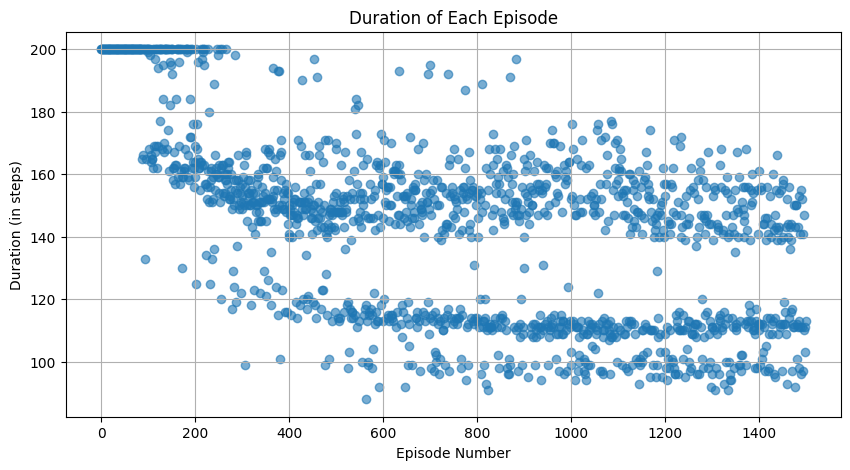

Training with #episodes = 3000 took 354.36059856414795 seconds.


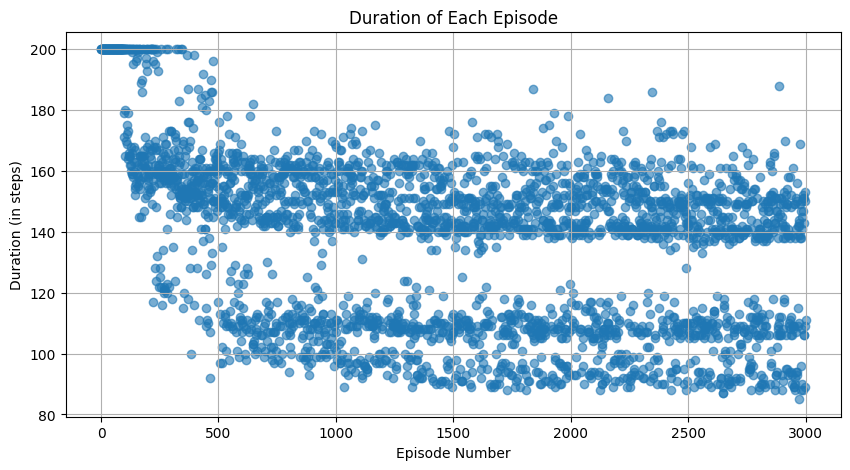

Training with #episodes = 4500 took 522.2627482414246 seconds.


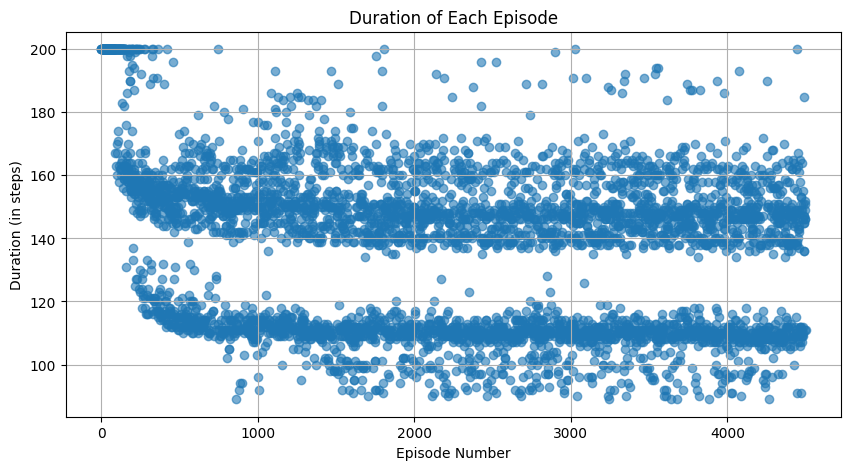

Training with #episodes = 6000 took 677.4658670425415 seconds.


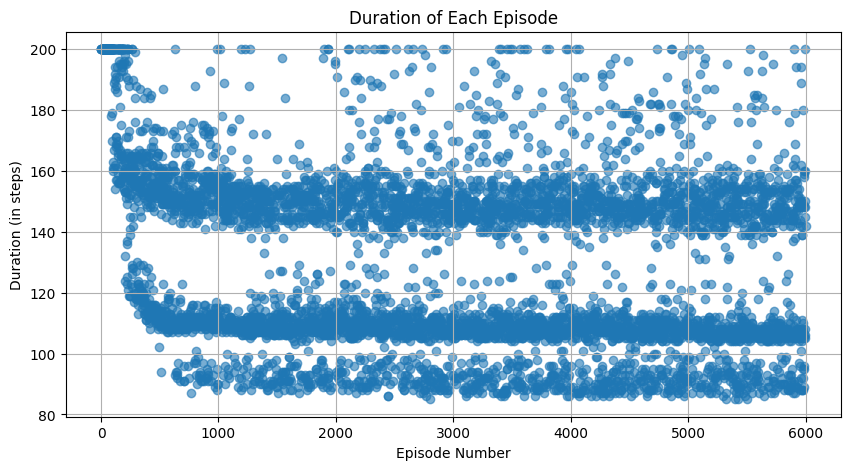

Training with #episodes = 7500 took 763.4076240062714 seconds.


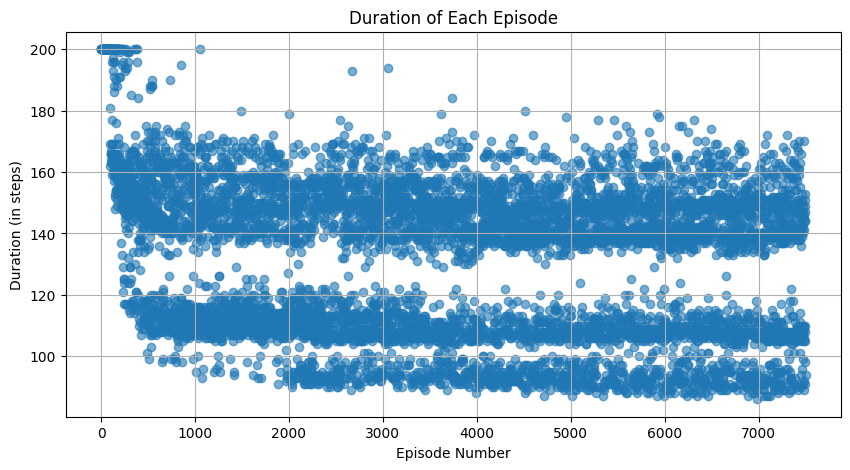

In [60]:
# We run the agent with different values for number_of_episodes
# Running the cell roughly takes 40 minutes
env = gym.make("MountainCar-v0")
for eps in [1500, 3000, 4500, 6000, 7500]:
    agent = DynaAgent(env, number_of_episodes=eps)
    start = time.time()
    durations, _, _, _ = agent.update()
    end = time.time()
    print(f"Training with #episodes = {eps} took {end - start} seconds.")
    plot_episode_durations(durations)

##### Question: When running the agent for a sufficiently large number of episodes, do you see a pattern in the episode duration plot? Try to find an explanation for this pattern.
The pattern consists of the agent starting to solve the problem consistently after roughly 300 episodes (as also mentioned in other tasks), and then starting to visibly fluctuate more and more between three ranges of durations needed to solve the problem. This fluctuation becomes more and more apparent with the number of episodes increasing since there seem to be only two fluctuation ranges with less episodes in the beginning.

The reason for this pattern might be rooted in the fact that the agent is placed in a range of different initial states (in [-0.6, -0.4] to be more precise) which are discretized to different state buckets. As such, the agent maybe procedes differently and for certain strategies requires more actions (i.e. when straight in the middle of the valley not starting with momentum) resulting into the seen pattern emerging, where the different fluctuation ranges correspond to different discrete bins from which the agent might start.

Nevertheless, the agent almost always solves the task which is desirable.

#### We rerun training with our fixed k = 10 and the number of episodes being set to 3000. This time, we illustrate the estimation of the Q-values after learning as described on the handout.

In [29]:
# Define a new function to plot the Q-values after learning
def plot_qValue_after_learning(takenBuffer, Q_vals, discPosis, discVelos):
    # Prepare the discrete version of the positions and the velocities for the x and y axis respectively
    discreteStates = [(discPosis[entry[2]], discVelos[entry[3]], entry[0]) for entry in takenBuffer]

    # Eliminate duplicate encounters of the same state as these do not matter for plotting
    discreteStates = list(set(discreteStates))

    # Prepare the maximum Q-values for the visited states
    qVals = [np.max(Q_vals[entry[2]]) for entry in discreteStates]

    # Plot the actual data in a scatter plot
    plt.scatter([coord[0] for coord in discreteStates], [coord[1] for coord in discreteStates], c=qVals, cmap='viridis')

    # Add labels and the title
    plt.xlabel("Car Position (discrete)")
    plt.ylabel("Car Velocity (discrete)")
    plt.title("Estimation of Q-Values after Learning")

    # Add color bar to show data points values
    plt.colorbar(label="Data Points")

    # Actually display the plot
    plt.show()

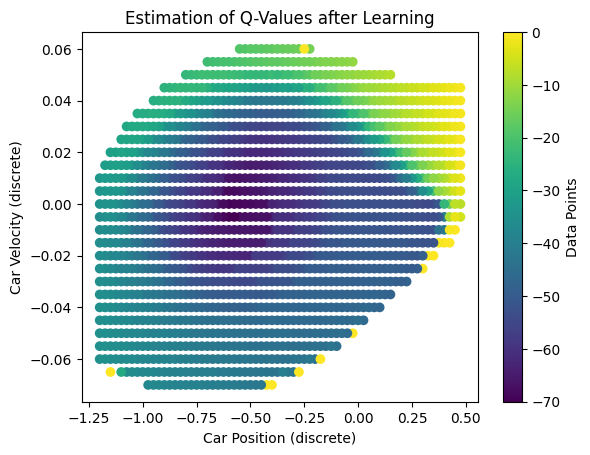

In [30]:
# Here, we rerun training to generate the estimation of the Q-values after learning
# Running the cell roughly takes 6 minutes
env = gym.make("MountainCar-v0")
agent = DynaAgent(env, number_of_episodes=3000)
agent.update()
plot_qValue_after_learning(agent.state_action_buffer, agent.Q, agent.discrete_positions, agent.discrete_velocities)

##### Question: What pattern do you see? Comment on the plot.
The estimation plot shows the Q-values for all the visited states after training an agent. Unsurprisingly, the Q-values in the middle of the plot corresponding to the car being in the middle of the valley with low speeds are assigned very low score. This is obvious as no action in this situtation can lead to much success soon which causes the agent to leave the valley which is desirable to solve the problem.

Bottom left values, which represent being on the left side uphill with negative velocities, are assigned higher scores but not optimal ones. Once again, this is plausible learning behavior since entering such a situation can lead to a problem solution in the near future when moving away, therefore assigning more reward than being in the valley. Nevertheless, the goal state is rather far away causing the scores not to be too high and spaeking drive away from these states.

Top right values give the highest scores which makes sense when recalling that the car then is on the right side of the hill with positive velocity, thereby approaching the goal state and solving the problem. Aprart from these values, there are some outlies with negative speeds giving high Q-value scores. These might stem from an optimal policy having been encountered in which the car performs a strong drive to the left and afterwards rapidly reaching the goal state due to building up sufficient momentum.

In conclusion. The plot gives patterns that correspond to the agent moving the car back and forth in the valley when moving in a circular fashion in the plot. This however is an optimal solution policy which supports our obsevation of the agent learning a stable policy.

#### Finally, we modify the above plot to show some episode trajectories on the same trained agent as in the preceding task.

In [44]:
# We reuse the function to plot Q-values after learning and highlight episode trajectories on top of it as required
def plot_qValue_after_learning_trajectories(takenBuffer, Q_vals, discPosis, discVelos, episodeIndicator, durations):
    # Prepare the discrete version of the positions and the velocities for the x and y axis respectively
    discreteStates = [(discPosis[entry[2]], discVelos[entry[3]], entry[0]) for entry in takenBuffer]

    # Eliminate duplicate encounters of the same state as these do not matter for plotting
    discreteStates = list(set(discreteStates))

    # Prepare the maximum Q-values for the visited states
    qVals = [np.max(Q_vals[entry[2]]) for entry in discreteStates]

    # Plot the actual data in a scatter plot
    plt.scatter([coord[0] for coord in discreteStates], [coord[1] for coord in discreteStates], c=qVals, cmap='viridis')

    # Add labels and the title
    plt.xlabel("Car Position (discrete)")
    plt.ylabel("Car Velocity (discrete)")
    plt.title("Estimation of Q-Values after Learning")

    # Add color bar to show data points values
    plt.colorbar(label="Data Points")

    # Find the indices of the points in the takenBuffer to connect to one-another
    startIndex = np.sum(np.array(durations[:(episodeIndicator-1)]))
    stopIndex = durations[episodeIndicator-1] + startIndex
    pointIndices = [(x, x+1) for x in range(int(startIndex), int(stopIndex))]
    pointIndices = pointIndices[:-1] # Drop the last connection as it would leave the episode space

    # Using the takenBuffer, find the points that must be connected
    connectedPoints = [(discPosis[takenBuffer[el[0]][2]], discVelos[takenBuffer[el[0]][3]],
                        discPosis[takenBuffer[el[1]][2]], discVelos[takenBuffer[el[1]][3]]) for el in pointIndices]

    # Plot the lines connecting the points
    x_coords = [coord[0] for coord in discreteStates]
    y_coords = [coord[1] for coord in discreteStates]
    for idx, (start_x, start_y, end_x, end_y) in enumerate(connectedPoints):
        if idx == 0:
            # Maybe change color here
            plt.plot([x_coords[x_coords.index(start_x)], x_coords[x_coords.index(end_x)]], [y_coords[y_coords.index(start_y)], y_coords[y_coords.index(end_y)]], color='red', linewidth=2, label=f'Traj. Ep.: {episodeIndicator}')
        elif idx == (len(connectedPoints)-1):
            # Maybe change color here
            plt.plot([x_coords[x_coords.index(start_x)], x_coords[x_coords.index(end_x)]], [y_coords[y_coords.index(start_y)], y_coords[y_coords.index(end_y)]], 'red', linewidth=2)
        else:
            plt.plot([x_coords[x_coords.index(start_x)], x_coords[x_coords.index(end_x)]], [y_coords[y_coords.index(start_y)], y_coords[y_coords.index(end_y)]], 'red', linewidth=2)
    
    # Display the legend
    plt.legend()

    # Actually display the plot
    plt.show()

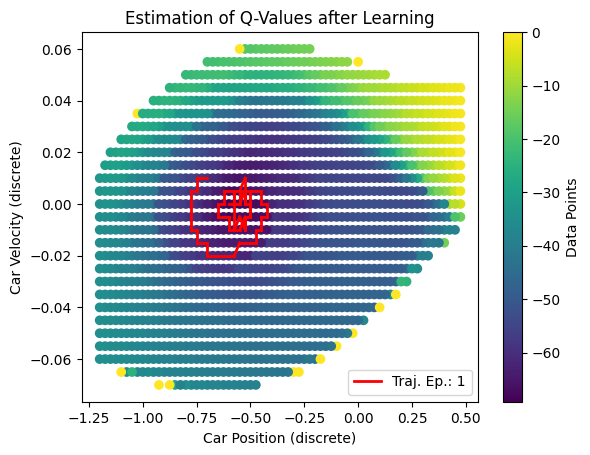

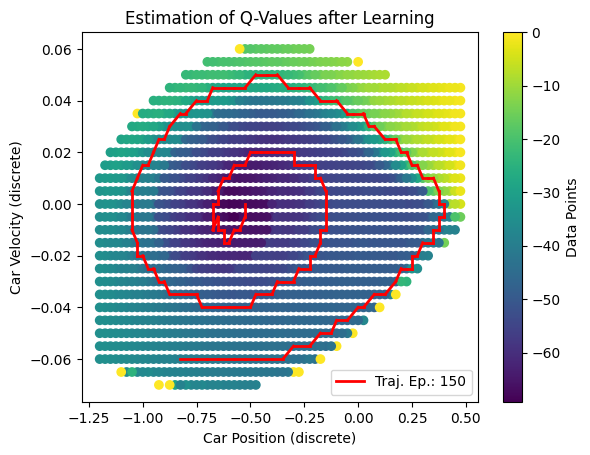

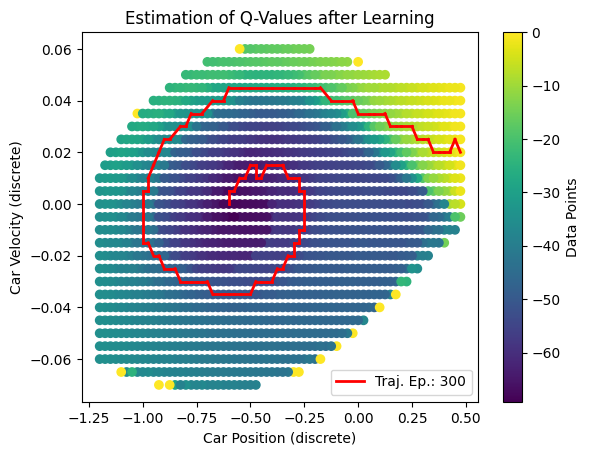

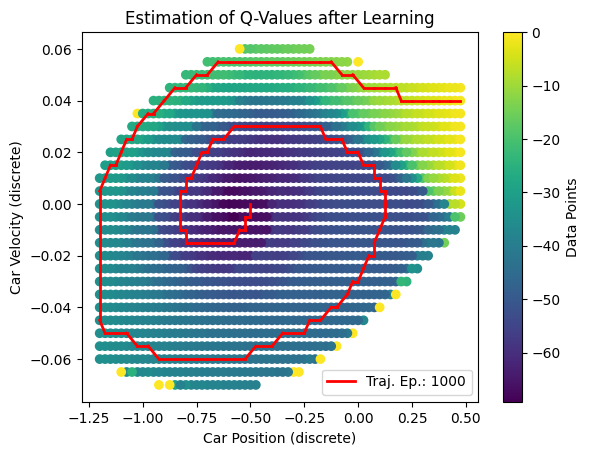

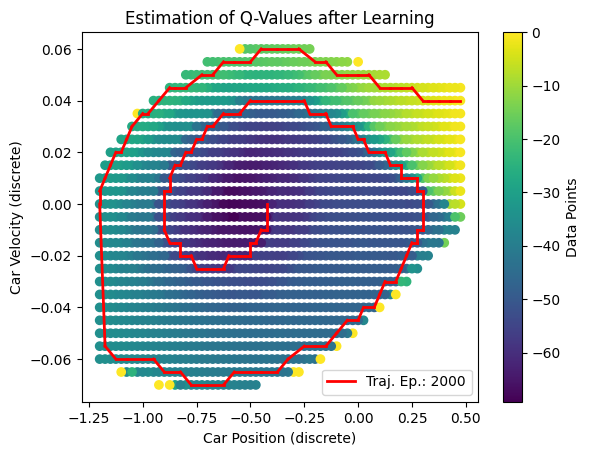

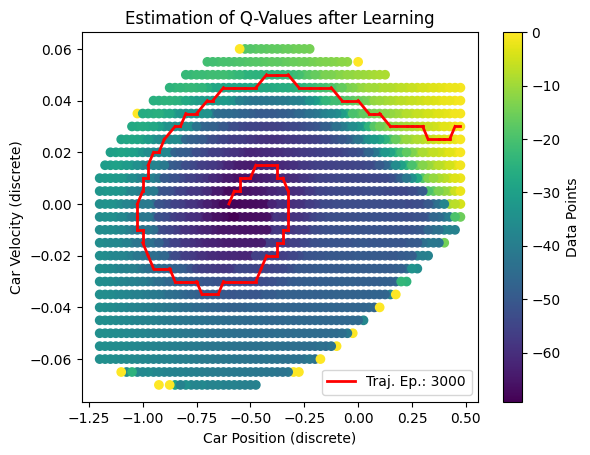

In [61]:
# Plot the trajectories in separate plots after rerunning training.
# Running the cell roughly takes 6 minutes
env = gym.make("MountainCar-v0")
agent = DynaAgent(env, number_of_episodes=3000)
durations, _, _, _ = agent.update()
# Create trajectories for different episodes.
for ep in [1, 150, 300, 1000, 2000, 3000]:
    plot_qValue_after_learning_trajectories(agent.state_action_buffer, agent.Q, agent.discrete_positions, agent.discrete_velocities, ep, durations)

##### Question: Can you relate what you see to the patterns in the episode duration plot? Explain.
The agent starts at different locations in the valley which correpond to the middle of the plot with low Q-scores. By then finding the more optimal states, he starts to tilt back and forth at chaning speeds before eventually reaching the goal state (not in all episodes which is visible by the line not reaching the corner points of the diagram) or aborting due to the timing limit.

Anyhow, one can see that in failing episodes (with a value of 200 in the episode duration plot) early on in training, the agent explores different adjacent states to build a model of the environment, which is reflected in the line sort of displaying random transitions between the states.

For failing episodes at a later point, which we also have a couple of, the agent does not explore anymore as the cirular pattern of the line from middle to the top right indicates him trying to escape the valley by building up momentum. However, the agent there does not employ an efficient tiliting strategy as it takes him too long to leave the valley to succeed with our metrics.

Successful episodes always display the aforementioned circular line pattern which correponds to moving back and forth. Variations there hint at different ways to accelerate and sligthly different valley starting points allowing for an easier momentum build-up and faster escape. Anyhow, other successful iterations take longer due to sligthly different starting points leading to evidently more inefficient tilting strategies.

That being said, the episode duration plot and the trajectories are correlated as lower number of episodes imply smaller cirular patterns and higher number of episodes imply random patterns when exploring or inefficient large cirucular patterns when exploiting.

### 4.5 Comparison with DQN

#### We create a plot where we compare the training performance of each of the three agents in terms of the environment rewards achieved by each one of them. For that, we rerun training on each agent, as this will also be useful for testing performance.

In [12]:
# Create a plotter function to compare training performance
def plot_performance(rewards, name):
    plt.figure()
    plt.plot(rewards, label='Environment Reward')
    plt.title('Rewards per Episode of ' + name)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()
    plt.show()

Episode 100/3000. Average reward: -281.38
Episode 200/3000. Average reward: -251.14
Episode 300/3000. Average reward: -217.11
Episode 400/3000. Average reward: -205.58
Episode 500/3000. Average reward: -192.69
Episode 600/3000. Average reward: -166.33
Episode 700/3000. Average reward: -173.62
Episode 800/3000. Average reward: -169.11
Episode 900/3000. Average reward: -193.62
Episode 1000/3000. Average reward: -170.59
Episode 1100/3000. Average reward: -167.09
Episode 1200/3000. Average reward: -196.20
Episode 1300/3000. Average reward: -160.28
Episode 1400/3000. Average reward: -176.16
Episode 1500/3000. Average reward: -174.78
Episode 1600/3000. Average reward: -161.24
Episode 1700/3000. Average reward: -170.73
Episode 1800/3000. Average reward: -171.34
Episode 1900/3000. Average reward: -189.56
Episode 2000/3000. Average reward: -206.45
Episode 2100/3000. Average reward: -220.27
Episode 2200/3000. Average reward: -196.21
Episode 2300/3000. Average reward: -208.62
Episode 2400/3000. A

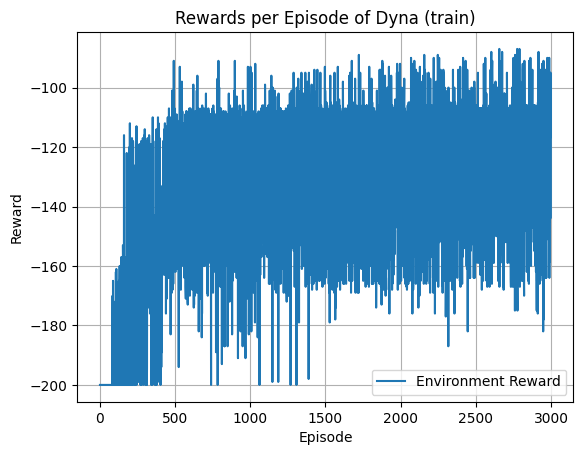

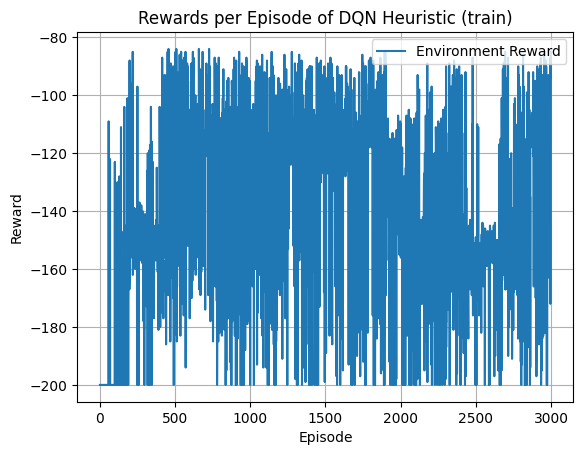

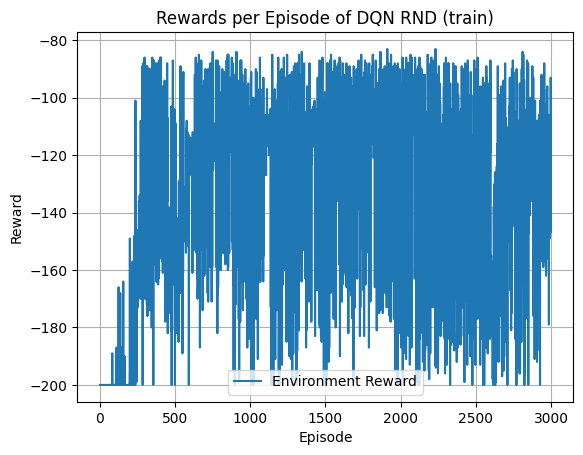

In [15]:
# Run training on each agent as requested and then plot the results using the above plotter function
# Running the cell roughly takes ... minutes
env = gym.make("MountainCar-v0")
agent = DynaAgent(env, number_of_episodes=3000)
_, rewards_dyna, _, _  = agent.update()

dqn_agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
_, rewards_heuristic, _, _, _, _ = train_dqn_with_auxiliary_reward(dqn_agent, env, num_episodes=3000)

dqn_rnd_agent = DQNAgent_RND(env.observation_space.shape[0], env.action_space.n)
_, rewards_rnd, _, _, _, _ = train_dqn_rnd(dqn_rnd_agent, env, num_episodes=3000)

# Plot results of training for everyone involved
plot_performance(rewards_dyna, "Dyna (train)")
plot_performance(rewards_heuristic, "DQN Heuristic (train)")
plot_performance(rewards_rnd, "DQN RND (train)")

##### Question: Comment on the results.
As seen alreday when evaluating Dyna in more detail, it gradually starts to solve the problem more and more reliably after the exploration phase ends after approximately 250 episodes. Furthermore, performance seems to converge and fluctuate between different ranges as already identified in its result section with respect to the episode duration patterns when increasing the number of episodes.

DQN with heuristic reward however does not seem to be held back by an exploration phase and starts to find solutions more readily. Anyhow, overall performance seems less stable when compared to Dyna, as there are certain points in time when it outperforms Dyna and finds even better solutions, whereas it randomly seems to fail as time progresses when Dyna never does so anymore. Finally, a dip in performance can be observed at episode 2500 roughly, which seems strange but has been touched upon in the DQN section.

DQN RND seems to strike a balance between the performance of Dyna and DQN with heuristic rewards. It also takes some time to explore before taking off and becoming stable for quite some time whilst outperforming Dyna and being more or less equivalent to DQN with heuristic reward. It also suffers from a performance drop after episode 2500 which does not happen in Dyna but recovers from it faster than DQN with heuristic rewards. Nevertheless, failures still do occur even at high episode counts.

#### We compare the testing performance on 1000 new episodes using our newly trained agents according to the instructions on the handout. We can reuse our previously defined plotter function for the sake of comparison.

Episode 100/1000. Average reward: -164.34
Episode 200/1000. Average reward: -167.31
Episode 300/1000. Average reward: -173.74
Episode 400/1000. Average reward: -163.15
Episode 500/1000. Average reward: -175.30
Episode 600/1000. Average reward: -170.85
Episode 700/1000. Average reward: -174.23
Episode 800/1000. Average reward: -174.33
Episode 900/1000. Average reward: -185.87
Episode 1000/1000. Average reward: -168.82
Episode 100/1000. Average reward: -112.91
Episode 200/1000. Average reward: -112.32
Episode 300/1000. Average reward: -113.85
Episode 400/1000. Average reward: -113.25
Episode 500/1000. Average reward: -112.81
Episode 600/1000. Average reward: -110.82
Episode 700/1000. Average reward: -107.97
Episode 800/1000. Average reward: -112.95
Episode 900/1000. Average reward: -113.27
Episode 1000/1000. Average reward: -111.24


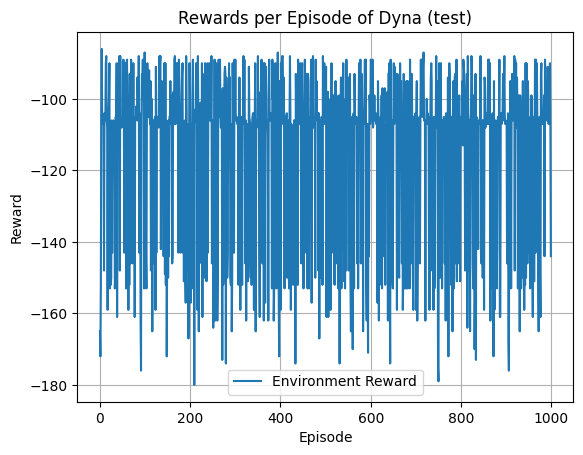

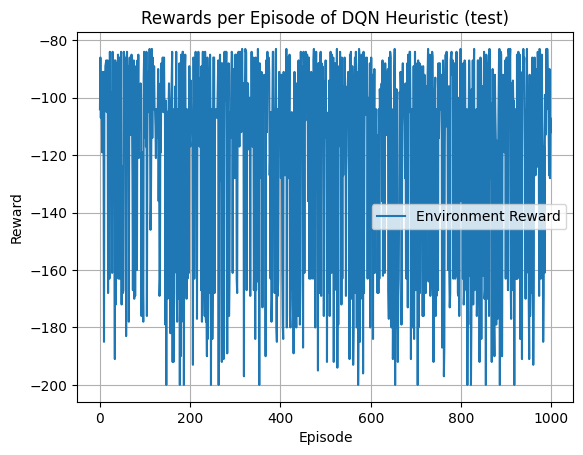

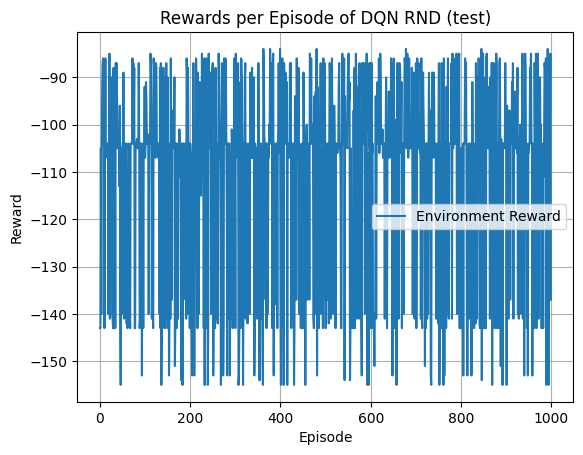

In [16]:
# Do testing and then reuse plotter functionality.
# Set epsilon to 0 everywhere as well as epsilon_min to prevent exploration
agent.epsilon = 0
agent.epsilon_min = 0

dqn_agent.epsilon = 0
dqn_agent.epsilon_min = 0

dqn_rnd_agent.epsilon = 0
dqn_rnd_agent.epsilon_min = 0

# Set all of the agents to run in test mode where no learning is performed and perform evaluation
agent.test = True
agent.number_of_episodes = 1000
_, rewards_dyna, _, _  = agent.update()

_, rewards_heuristic, _, _, _, _ = train_dqn_with_auxiliary_reward(dqn_agent, env, num_episodes=1000, test=True)

_, rewards_rnd, _, _, _, _ = train_dqn_rnd(dqn_rnd_agent, env, num_episodes=1000, test=True)

# Plot results of training for everyone involved
plot_performance(rewards_dyna, "Dyna (test)")
plot_performance(rewards_heuristic, "DQN Heuristic (test)")
plot_performance(rewards_rnd, "DQN RND (test)")

##### Question: Comment on the results.
When testing the performance of the three learned policies on the mountain car environment without exploration and learning switched off, all the agents show a rather similar pattern. Performance in terms of episode rates seems to osciallte in a specific range, where DQN with heuristic reward has the greatest of them all ranging from the best scores to some failures occurring. DQN RND and Dyna never fail in the test environment but DQN RND seems to outperform Dyna as its range is more condensed in lower episode counts than it is the case with Dyna.

### 5 Conclusion

Can be written in report solely.